<a href="https://colab.research.google.com/github/Stanfording/small_GAN_testing/blob/main/64_cele_small_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Goal:   Just get a small GAN running



Get the preprocessed celebHD data from google drive

In [1]:
# #Download the dataset
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN" -O "proCeleba.zip" && rm -rf /tmp/cookies.txt

# #unzip the dataset
# !unzip "/content/proCeleba.zip"

# #remove unnecessary files
# !rm -rf /content/__MACOSX

Streaming output truncated to the last 5000 lines.
  inflating: proCeleba/512/052408.jpg  
  inflating: proCeleba/512/045174.jpg  
  inflating: proCeleba/512/018267.jpg  
  inflating: proCeleba/512/155415.jpg  
  inflating: proCeleba/512/077878.jpg  
  inflating: proCeleba/512/068958.jpg  
  inflating: proCeleba/512/008074.jpg  
  inflating: proCeleba/512/145606.jpg  
  inflating: proCeleba/512/191331.jpg  
  inflating: proCeleba/512/007347.jpg  
  inflating: proCeleba/512/041312.jpg  
  inflating: proCeleba/512/115031.jpg  
  inflating: proCeleba/512/006059.jpg  
  inflating: proCeleba/512/186895.jpg  
  inflating: proCeleba/512/200484.jpg  
  inflating: proCeleba/512/198473.jpg  
  inflating: proCeleba/512/001050.jpg  
  inflating: proCeleba/512/197026.jpg  
  inflating: proCeleba/512/021380.jpg  
  inflating: proCeleba/512/056108.jpg  
  inflating: proCeleba/512/163819.jpg  
  inflating: proCeleba/512/018501.jpg  
  inflating: proCeleba/512/085350.jpg  
  inflating: proCeleba/512/15

## Import libraries

In [2]:
#!python3 -m pip install -f https://release.oneflow.info oneflow==0.7.0+cu102

In [3]:
#import oneflow as t

In [4]:
from tqdm import tqdm

from torch.autograd import Variable, grad
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import os
import torch as t
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from skimage import io
import copy

### Set initial hyperparameters

In [5]:

batch_size = 64

resolution = 16

img_fold_dir_64_reso = f"/content/proCeleba/{resolution}"

iteration = 500

critic = 28000 // batch_size // 5      

eval_size = 25

laten_space = 100

updatD_step = 5

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

log_folder = "log"
!mkdir "log"
!mkdir "log/checkpoint"
!mkdir "log/sample"

### Show me which gpu I am using.

In [6]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-8cf634ef-a785-7644-f5a1-34e012f57315)


### Pre loading the data

In [7]:
# Define a data class for load unclassfied data.
class Get_No_Classes_Img_Dataset(Dataset):
    
    def __init__(self, folder_dir, transform = None):
        self.folder_dir = os.path.join(folder_dir)
        self.transform = transform
        self.image_list = os.listdir(self.folder_dir)
        
    def __len__(self):
        return len(os.listdir(self.folder_dir))
    
    def __getitem__(self, index):
        
        image_name = self.image_list[index]
        
        image_dir = os.path.join(self.folder_dir, image_name)
        
        image = io.imread(image_dir)
        
        if (self.transform != None):
            image = self.transform(image)
        
        return image
    

transform = transforms.Compose([
    transforms.ToTensor(),        #From Batch * Highth * Width * Channel to Batch * Channel * Highth * Width
                                  #Which is what pytorch CNN can work with.
                                
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
]) 
dataset = Get_No_Classes_Img_Dataset(img_fold_dir_64_reso, transform = transform) 
                                                            # datasets[0].shape = (16,16,3)
                                                            # len(datasets) = 28000
total_data_len = len(dataset)
                                                                                            
#datasets_batched = DataLoader(datasets, batch_size = batch_size) #loader is renewed every epoch




```
loader = iter(loader)
print(next(loader).shape) 
```
will output


```
torch.Size([batch_size, 3, resolution, resolution])
```

So data loading is ready.

What's left is keep using 

```
next(loader)
```
to access each batch of data


### Visualize a picture

In [8]:
from IPython.display import Image, display




# Viewing one data sample function:
def showOneImge(img, i, shouldSave):
    
    img = img.squeeze()
    
    img = transforms.ToPILImage()(img)
    
    plt.figure(figsize = (10,10), dpi = 10)
    plt.axis('off')
    
    if shouldSave:
      saveDir = f'{log_folder}/sample/{str(i).zfill(6)}.png'
      plt.imshow(img)
      plt.savefig(saveDir, bbox_inches='tight', pad_inches = 0)
      img = Image(saveDir)
      display(img)
    else:
      deleteDir = f"{log_folder}/sample/Delete.png"
      plt.imshow(img)
      plt.savefig(deleteDir, bbox_inches='tight', pad_inches = 0)
      img = Image(deleteDir)
      display(img)
      !rm "/content/log/sample/Delete.png"
    return 

''' Testing showOneImage'''
# loader = DataLoader(datasets, batch_size = batch_size)

# data = iter(loader)

# oneSample = next(data)[0]

# showOneImge(oneSample, 9999, True)


def showMoreImages(img, num):

  subplot_x = int(num ** (1/2))
  subplot_y = num // subplot_x
  plt.figure(figsize = (2,2))
  for i in range(len(img)):
      aimg = transforms.ToPILImage()(img[i])
      plt.subplot(subplot_x, subplot_y, i+1)
      plt.imshow(aimg)
      plt.axis('off')


-------------------------------------------------

### Now Designing the simple GAN network

In [9]:
"""
Define the generator
"""

class G(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.laten = nn.Sequential(
            nn.Linear(laten_space, 100),
            nn.Linear(100, 500),
            nn.Linear(500, 128 * resolution * resolution))

        self.model = nn.Sequential(
            nn.Conv2d(128, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 3, (3, 3), padding = "same"),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, theInput, batch_size):
        
        x = self.laten(theInput)
        
        x = t.reshape(x, (batch_size, 128, resolution, resolution))
         
        x = self.model(x)
            
            
        return x
    
class D(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.netWork = nn.Sequential(
            nn.Conv2d(3, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, (3, 3), stride = (3, 3)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 1, (3, 3), stride = (3, 3)),
            nn.Flatten())
        
    def forward(self, theInput):
        
        return self.netWork(theInput)

### Testing the network

In [10]:
"""

Testing the net work:

"""

# oneImg = next(iter(datasets))[0]

# showOneImge(oneImg, 0)

# oneImg = oneImg.expand(1,3,64,64)

# print(oneImg.shape)

# print(oneImg)

# #img into G to test shape

# input_noise_example = t.randn((batch_size, 1, 1, 5))

# a = G()(input_noise_example, batch_size)
# print(a[0])
# showOneImge(a[0], 0)

# b = D()(next(loader))

# print(b.shape)

'\n\nTesting the net work:\n\n'

### Gradient Penalty from wGAN.

In [11]:
def compute_gradient_penalty(D, real_samples, fake_samples, current_batch_size):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = t.randn((current_batch_size, 1, 1, 1)).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    
    d_interpolates = D(interpolates)
    
    
    grad_x_hat = grad(
            outputs=d_interpolates.sum(), inputs=interpolates, create_graph=True)[0]
    grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1)
                      .norm(2, dim=1) - 1)**2).mean()
    grad_penalty = 10 * grad_penalty
    
    return grad_penalty

### Try FID LOSS

In [12]:
#This is from https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# example of calculating the frechet inception distance
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
 
# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid





### Initializing the generator, discriminator, optimizer, labels, and loss.

In [13]:
generator = G().to(device)
discriminator = D().to(device)
discriminatorReal = D().to(device)

G_optimizer = t.optim.Adam(generator.parameters(), lr = 0.00001)
D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.00001)

label_real = t.ones((batch_size, 1)).to(device)
label_fake = t.zeros((batch_size, 1)).to(device)


### Start training

Epoch: 1: 100%|██████████| 438/438 [00:35<00:00, 12.50it/s, D_total_loss=-.107, G_loss=0.728, fake_score=-.514, real_score=-.326]


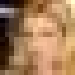

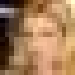

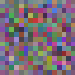

epoch =  1
Epoch [0/500], Step [438/438], d_loss: -0.1068, g_loss: 0.7280, D(x): -0.33, D(G(z)): -0.51


Epoch: 3: 100%|██████████| 438/438 [00:21<00:00, 20.48it/s, D_total_loss=-.36, G_loss=0.779, fake_score=-.603, real_score=-.188]


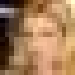

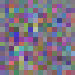

epoch =  3
Epoch [2/500], Step [438/438], d_loss: -0.3598, g_loss: 0.7789, D(x): -0.19, D(G(z)): -0.60


Epoch: 5: 100%|██████████| 438/438 [00:20<00:00, 21.52it/s, D_total_loss=-.484, G_loss=0.812, fake_score=-.587, real_score=-.0382]


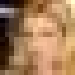

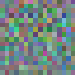

epoch =  5
Epoch [4/500], Step [438/438], d_loss: -0.4842, g_loss: 0.8123, D(x): -0.04, D(G(z)): -0.59


Epoch: 7: 100%|██████████| 438/438 [00:20<00:00, 20.97it/s, D_total_loss=-.639, G_loss=0.836, fake_score=-.614, real_score=0.0975]


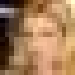

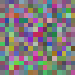

epoch =  7
Epoch [6/500], Step [438/438], d_loss: -0.6388, g_loss: 0.8355, D(x): 0.10, D(G(z)): -0.61


Epoch: 9: 100%|██████████| 438/438 [00:21<00:00, 20.84it/s, D_total_loss=-.579, G_loss=0.88, fake_score=-.622, real_score=0.188]


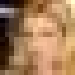

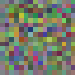

epoch =  9
Epoch [8/500], Step [438/438], d_loss: -0.5795, g_loss: 0.8801, D(x): 0.19, D(G(z)): -0.62


Epoch: 11: 100%|██████████| 438/438 [00:22<00:00, 19.58it/s, D_total_loss=-.806, G_loss=0.91, fake_score=-.679, real_score=0.239]


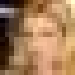

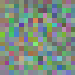

epoch =  11
Epoch [10/500], Step [438/438], d_loss: -0.8057, g_loss: 0.9102, D(x): 0.24, D(G(z)): -0.68


Epoch: 13: 100%|██████████| 438/438 [00:20<00:00, 21.15it/s, D_total_loss=-1.07, G_loss=0.958, fake_score=-.718, real_score=0.411]


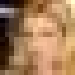

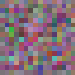

epoch =  13
Epoch [12/500], Step [438/438], d_loss: -1.0695, g_loss: 0.9582, D(x): 0.41, D(G(z)): -0.72


Epoch: 15: 100%|██████████| 438/438 [00:20<00:00, 21.87it/s, D_total_loss=-1.11, G_loss=1.04, fake_score=-.719, real_score=0.434]


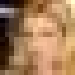

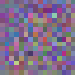

epoch =  15
Epoch [14/500], Step [438/438], d_loss: -1.1076, g_loss: 1.0357, D(x): 0.43, D(G(z)): -0.72


Epoch: 17: 100%|██████████| 438/438 [00:19<00:00, 22.09it/s, D_total_loss=-1.26, G_loss=1.17, fake_score=-.921, real_score=0.472]


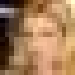

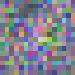

epoch =  17
Epoch [16/500], Step [438/438], d_loss: -1.2582, g_loss: 1.1659, D(x): 0.47, D(G(z)): -0.92


Epoch: 19: 100%|██████████| 438/438 [00:20<00:00, 21.56it/s, D_total_loss=-1.23, G_loss=1.16, fake_score=-.813, real_score=0.565]


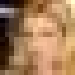

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


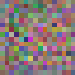

epoch =  19
Epoch [18/500], Step [438/438], d_loss: -1.2259, g_loss: 1.1600, D(x): 0.56, D(G(z)): -0.81


Epoch: 21: 100%|██████████| 438/438 [00:20<00:00, 21.37it/s, D_total_loss=-1.35, G_loss=1.2, fake_score=-.933, real_score=0.479]


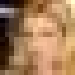

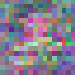

epoch =  21
Epoch [20/500], Step [438/438], d_loss: -1.3455, g_loss: 1.2027, D(x): 0.48, D(G(z)): -0.93


Epoch: 23: 100%|██████████| 438/438 [00:20<00:00, 20.98it/s, D_total_loss=-1.31, G_loss=1.21, fake_score=-1.07, real_score=0.3]


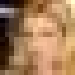

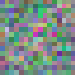

epoch =  23
Epoch [22/500], Step [438/438], d_loss: -1.3078, g_loss: 1.2133, D(x): 0.30, D(G(z)): -1.07


Epoch: 25: 100%|██████████| 438/438 [00:20<00:00, 21.72it/s, D_total_loss=-1.28, G_loss=1.3, fake_score=-.932, real_score=0.404]


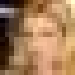

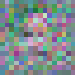

epoch =  25
Epoch [24/500], Step [438/438], d_loss: -1.2772, g_loss: 1.3029, D(x): 0.40, D(G(z)): -0.93


Epoch: 27: 100%|██████████| 438/438 [00:20<00:00, 21.16it/s, D_total_loss=-1.24, G_loss=1.37, fake_score=-.973, real_score=0.31]


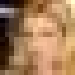

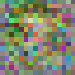

epoch =  27
Epoch [26/500], Step [438/438], d_loss: -1.2350, g_loss: 1.3715, D(x): 0.31, D(G(z)): -0.97


Epoch: 29: 100%|██████████| 438/438 [00:20<00:00, 21.76it/s, D_total_loss=-1.33, G_loss=1.45, fake_score=-1.29, real_score=0.229]


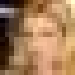

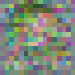

epoch =  29
Epoch [28/500], Step [438/438], d_loss: -1.3306, g_loss: 1.4481, D(x): 0.23, D(G(z)): -1.29


Epoch: 31: 100%|██████████| 438/438 [00:21<00:00, 20.32it/s, D_total_loss=-1.35, G_loss=1.69, fake_score=-1.25, real_score=0.159]


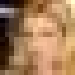

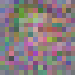

epoch =  31
Epoch [30/500], Step [438/438], d_loss: -1.3529, g_loss: 1.6905, D(x): 0.16, D(G(z)): -1.25


Epoch: 33: 100%|██████████| 438/438 [00:21<00:00, 20.41it/s, D_total_loss=-1.3, G_loss=1.86, fake_score=-1.28, real_score=0.0817]


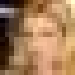

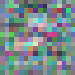

epoch =  33
Epoch [32/500], Step [438/438], d_loss: -1.2953, g_loss: 1.8635, D(x): 0.08, D(G(z)): -1.28


Epoch: 35: 100%|██████████| 438/438 [00:21<00:00, 20.40it/s, D_total_loss=-1.52, G_loss=2, fake_score=-1.62, real_score=-.00328]


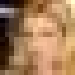

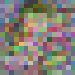

epoch =  35
Epoch [34/500], Step [438/438], d_loss: -1.5167, g_loss: 1.9954, D(x): -0.00, D(G(z)): -1.62


Epoch: 37: 100%|██████████| 438/438 [00:21<00:00, 20.10it/s, D_total_loss=-1.5, G_loss=2.26, fake_score=-1.68, real_score=-.0761]


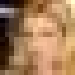

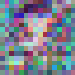

epoch =  37
Epoch [36/500], Step [438/438], d_loss: -1.4982, g_loss: 2.2592, D(x): -0.08, D(G(z)): -1.68


Epoch: 39: 100%|██████████| 438/438 [00:21<00:00, 20.40it/s, D_total_loss=-1.45, G_loss=2.41, fake_score=-2.01, real_score=-.253]


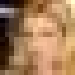

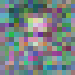

epoch =  39
Epoch [38/500], Step [438/438], d_loss: -1.4526, g_loss: 2.4109, D(x): -0.25, D(G(z)): -2.01


Epoch: 41: 100%|██████████| 438/438 [00:20<00:00, 21.01it/s, D_total_loss=-1.62, G_loss=2.62, fake_score=-2.11, real_score=-.435]


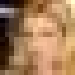

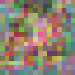

epoch =  41
Epoch [40/500], Step [438/438], d_loss: -1.6196, g_loss: 2.6153, D(x): -0.43, D(G(z)): -2.11


Epoch: 43: 100%|██████████| 438/438 [00:21<00:00, 20.85it/s, D_total_loss=-1.67, G_loss=2.89, fake_score=-2.52, real_score=-.581]


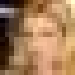

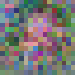

epoch =  43
Epoch [42/500], Step [438/438], d_loss: -1.6673, g_loss: 2.8881, D(x): -0.58, D(G(z)): -2.52


Epoch: 45: 100%|██████████| 438/438 [00:21<00:00, 20.16it/s, D_total_loss=-1.89, G_loss=3.09, fake_score=-2.49, real_score=-.53]


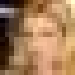

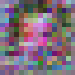

epoch =  45
Epoch [44/500], Step [438/438], d_loss: -1.8884, g_loss: 3.0892, D(x): -0.53, D(G(z)): -2.49


Epoch: 47: 100%|██████████| 438/438 [00:22<00:00, 19.35it/s, D_total_loss=-1.76, G_loss=3.03, fake_score=-2.57, real_score=-.693]


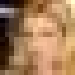

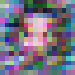

epoch =  47
Epoch [46/500], Step [438/438], d_loss: -1.7629, g_loss: 3.0275, D(x): -0.69, D(G(z)): -2.57


Epoch: 49: 100%|██████████| 438/438 [00:22<00:00, 19.42it/s, D_total_loss=-1.85, G_loss=3.38, fake_score=-2.96, real_score=-.863]


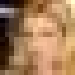

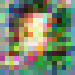

epoch =  49
Epoch [48/500], Step [438/438], d_loss: -1.8479, g_loss: 3.3768, D(x): -0.86, D(G(z)): -2.96


Epoch: 51: 100%|██████████| 438/438 [00:22<00:00, 19.55it/s, D_total_loss=-.623, G_loss=3.39, fake_score=-2.9, real_score=-.909]


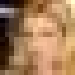

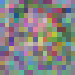

epoch =  51
Epoch [50/500], Step [438/438], d_loss: -0.6232, g_loss: 3.3897, D(x): -0.91, D(G(z)): -2.90


Epoch: 53: 100%|██████████| 438/438 [00:22<00:00, 19.61it/s, D_total_loss=-1.94, G_loss=3.61, fake_score=-3.22, real_score=-1.05]


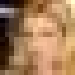

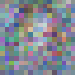

epoch =  53
Epoch [52/500], Step [438/438], d_loss: -1.9436, g_loss: 3.6147, D(x): -1.05, D(G(z)): -3.22


Epoch: 55: 100%|██████████| 438/438 [00:22<00:00, 19.36it/s, D_total_loss=-1.94, G_loss=3.55, fake_score=-3.26, real_score=-1.13]


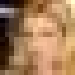

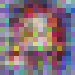

epoch =  55
Epoch [54/500], Step [438/438], d_loss: -1.9351, g_loss: 3.5484, D(x): -1.13, D(G(z)): -3.26


Epoch: 57: 100%|██████████| 438/438 [00:21<00:00, 20.53it/s, D_total_loss=-2.2, G_loss=3.62, fake_score=-3.46, real_score=-1.18]


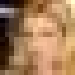

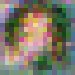

epoch =  57
Epoch [56/500], Step [438/438], d_loss: -2.1950, g_loss: 3.6198, D(x): -1.18, D(G(z)): -3.46


Epoch: 59: 100%|██████████| 438/438 [00:22<00:00, 19.82it/s, D_total_loss=-1.83, G_loss=3.72, fake_score=-3.55, real_score=-1.37]


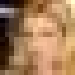

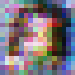

epoch =  59
Epoch [58/500], Step [438/438], d_loss: -1.8252, g_loss: 3.7244, D(x): -1.37, D(G(z)): -3.55


Epoch: 61: 100%|██████████| 438/438 [00:24<00:00, 18.21it/s, D_total_loss=-2.03, G_loss=3.72, fake_score=-3.52, real_score=-1.32]


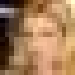

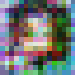

epoch =  61
Epoch [60/500], Step [438/438], d_loss: -2.0300, g_loss: 3.7213, D(x): -1.32, D(G(z)): -3.52


Epoch: 63: 100%|██████████| 438/438 [00:25<00:00, 17.51it/s, D_total_loss=-2.12, G_loss=3.82, fake_score=-3.56, real_score=-1.26]


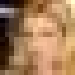

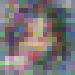

epoch =  63
Epoch [62/500], Step [438/438], d_loss: -2.1223, g_loss: 3.8249, D(x): -1.26, D(G(z)): -3.56


Epoch: 65: 100%|██████████| 438/438 [00:23<00:00, 19.01it/s, D_total_loss=-1.98, G_loss=3.53, fake_score=-3.38, real_score=-1.25]


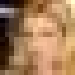

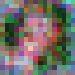

epoch =  65
Epoch [64/500], Step [438/438], d_loss: -1.9806, g_loss: 3.5288, D(x): -1.25, D(G(z)): -3.38


Epoch: 67: 100%|██████████| 438/438 [00:22<00:00, 19.86it/s, D_total_loss=-2.18, G_loss=3.72, fake_score=-3.55, real_score=-1.22]


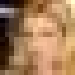

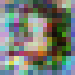

epoch =  67
Epoch [66/500], Step [438/438], d_loss: -2.1788, g_loss: 3.7224, D(x): -1.22, D(G(z)): -3.55


Epoch: 69: 100%|██████████| 438/438 [00:21<00:00, 20.05it/s, D_total_loss=-1.89, G_loss=3.44, fake_score=-3.26, real_score=-1.25]


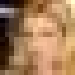

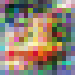

epoch =  69
Epoch [68/500], Step [438/438], d_loss: -1.8911, g_loss: 3.4427, D(x): -1.25, D(G(z)): -3.26


Epoch: 71: 100%|██████████| 438/438 [00:23<00:00, 18.47it/s, D_total_loss=-1.95, G_loss=3.5, fake_score=-3.19, real_score=-1.15]


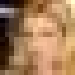

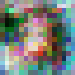

epoch =  71
Epoch [70/500], Step [438/438], d_loss: -1.9542, g_loss: 3.4991, D(x): -1.15, D(G(z)): -3.19


Epoch: 73: 100%|██████████| 438/438 [00:22<00:00, 19.23it/s, D_total_loss=-1.65, G_loss=3.19, fake_score=-3.04, real_score=-1.23]


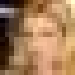

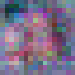

epoch =  73
Epoch [72/500], Step [438/438], d_loss: -1.6544, g_loss: 3.1942, D(x): -1.23, D(G(z)): -3.04


Epoch: 75: 100%|██████████| 438/438 [00:23<00:00, 18.93it/s, D_total_loss=-1.87, G_loss=3.05, fake_score=-3.11, real_score=-1.14]


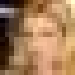

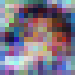

epoch =  75
Epoch [74/500], Step [438/438], d_loss: -1.8741, g_loss: 3.0529, D(x): -1.14, D(G(z)): -3.11


Epoch: 77: 100%|██████████| 438/438 [00:23<00:00, 19.01it/s, D_total_loss=-1.34, G_loss=2.93, fake_score=-2.65, real_score=-1.12]


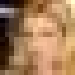

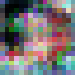

epoch =  77
Epoch [76/500], Step [438/438], d_loss: -1.3440, g_loss: 2.9328, D(x): -1.12, D(G(z)): -2.65


Epoch: 79: 100%|██████████| 438/438 [00:22<00:00, 19.76it/s, D_total_loss=-1.68, G_loss=2.72, fake_score=-2.54, real_score=-.709]


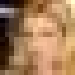

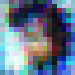

epoch =  79
Epoch [78/500], Step [438/438], d_loss: -1.6834, g_loss: 2.7171, D(x): -0.71, D(G(z)): -2.54


Epoch: 81: 100%|██████████| 438/438 [00:21<00:00, 20.01it/s, D_total_loss=-1.35, G_loss=2.66, fake_score=-2.61, real_score=-1.03]


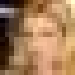

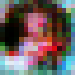

epoch =  81
Epoch [80/500], Step [438/438], d_loss: -1.3498, g_loss: 2.6616, D(x): -1.03, D(G(z)): -2.61


Epoch: 83: 100%|██████████| 438/438 [00:22<00:00, 19.47it/s, D_total_loss=-1.57, G_loss=2.53, fake_score=-2.56, real_score=-.843]


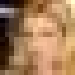

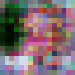

epoch =  83
Epoch [82/500], Step [438/438], d_loss: -1.5731, g_loss: 2.5327, D(x): -0.84, D(G(z)): -2.56


Epoch: 85: 100%|██████████| 438/438 [00:24<00:00, 18.05it/s, D_total_loss=-1.39, G_loss=2.25, fake_score=-2.36, real_score=-.837]


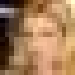

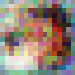

epoch =  85
Epoch [84/500], Step [438/438], d_loss: -1.3883, g_loss: 2.2477, D(x): -0.84, D(G(z)): -2.36


Epoch: 87: 100%|██████████| 438/438 [00:24<00:00, 17.92it/s, D_total_loss=-1.15, G_loss=2.23, fake_score=-1.99, real_score=-.618]


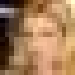

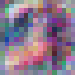

epoch =  87
Epoch [86/500], Step [438/438], d_loss: -1.1523, g_loss: 2.2252, D(x): -0.62, D(G(z)): -1.99


Epoch: 89: 100%|██████████| 438/438 [00:24<00:00, 18.16it/s, D_total_loss=-1.81, G_loss=2.1, fake_score=-2.37, real_score=-.48]


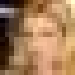

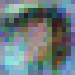

epoch =  89
Epoch [88/500], Step [438/438], d_loss: -1.8135, g_loss: 2.1045, D(x): -0.48, D(G(z)): -2.37


Epoch: 91: 100%|██████████| 438/438 [00:24<00:00, 18.05it/s, D_total_loss=-1.13, G_loss=2.23, fake_score=-1.99, real_score=-.663]


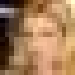

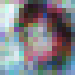

epoch =  91
Epoch [90/500], Step [438/438], d_loss: -1.1343, g_loss: 2.2270, D(x): -0.66, D(G(z)): -1.99


Epoch: 93: 100%|██████████| 438/438 [00:22<00:00, 19.06it/s, D_total_loss=-.116, G_loss=2.24, fake_score=-2.21, real_score=-.546]


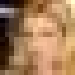

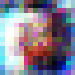

epoch =  93
Epoch [92/500], Step [438/438], d_loss: -0.1165, g_loss: 2.2381, D(x): -0.55, D(G(z)): -2.21


Epoch: 95: 100%|██████████| 438/438 [00:23<00:00, 19.01it/s, D_total_loss=-1.44, G_loss=2.14, fake_score=-2.11, real_score=-.386]


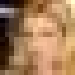

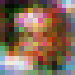

epoch =  95
Epoch [94/500], Step [438/438], d_loss: -1.4432, g_loss: 2.1373, D(x): -0.39, D(G(z)): -2.11


Epoch: 97: 100%|██████████| 438/438 [00:22<00:00, 19.85it/s, D_total_loss=-1.36, G_loss=2.1, fake_score=-1.97, real_score=-.562]


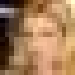

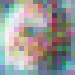

epoch =  97
Epoch [96/500], Step [438/438], d_loss: -1.3583, g_loss: 2.1026, D(x): -0.56, D(G(z)): -1.97


Epoch: 99: 100%|██████████| 438/438 [00:23<00:00, 18.92it/s, D_total_loss=-1.66, G_loss=2.13, fake_score=-2.29, real_score=-.483]


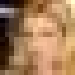

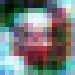

epoch =  99
Epoch [98/500], Step [438/438], d_loss: -1.6624, g_loss: 2.1343, D(x): -0.48, D(G(z)): -2.29


Epoch: 101: 100%|██████████| 438/438 [00:25<00:00, 17.21it/s, D_total_loss=-1.27, G_loss=1.86, fake_score=-2.02, real_score=-.463]


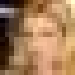

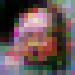

epoch =  101
Epoch [100/500], Step [438/438], d_loss: -1.2712, g_loss: 1.8631, D(x): -0.46, D(G(z)): -2.02


Epoch: 103: 100%|██████████| 438/438 [00:24<00:00, 17.73it/s, D_total_loss=-1.81, G_loss=2.1, fake_score=-2.44, real_score=-.522]


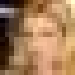

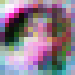

epoch =  103
Epoch [102/500], Step [438/438], d_loss: -1.8106, g_loss: 2.0956, D(x): -0.52, D(G(z)): -2.44


Epoch: 105: 100%|██████████| 438/438 [00:23<00:00, 18.80it/s, D_total_loss=-.573, G_loss=1.81, fake_score=-1.91, real_score=-.426]


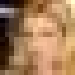

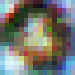

epoch =  105
Epoch [104/500], Step [438/438], d_loss: -0.5727, g_loss: 1.8106, D(x): -0.43, D(G(z)): -1.91


Epoch: 107: 100%|██████████| 438/438 [00:23<00:00, 18.54it/s, D_total_loss=-1.66, G_loss=2.09, fake_score=-2.05, real_score=-.284]


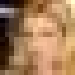

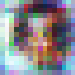

epoch =  107
Epoch [106/500], Step [438/438], d_loss: -1.6576, g_loss: 2.0927, D(x): -0.28, D(G(z)): -2.05


Epoch: 109: 100%|██████████| 438/438 [00:23<00:00, 18.77it/s, D_total_loss=-1.43, G_loss=2.1, fake_score=-1.93, real_score=-.355]


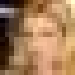

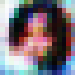

epoch =  109
Epoch [108/500], Step [438/438], d_loss: -1.4300, g_loss: 2.1036, D(x): -0.36, D(G(z)): -1.93


Epoch: 111: 100%|██████████| 438/438 [00:22<00:00, 19.18it/s, D_total_loss=-1.6, G_loss=2.01, fake_score=-1.94, real_score=-.268]


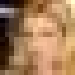

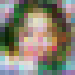

epoch =  111
Epoch [110/500], Step [438/438], d_loss: -1.5974, g_loss: 2.0065, D(x): -0.27, D(G(z)): -1.94


Epoch: 113: 100%|██████████| 438/438 [00:22<00:00, 19.06it/s, D_total_loss=-1.77, G_loss=2.09, fake_score=-2.09, real_score=-.164]


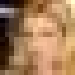

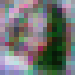

epoch =  113
Epoch [112/500], Step [438/438], d_loss: -1.7696, g_loss: 2.0890, D(x): -0.16, D(G(z)): -2.09


Epoch: 115: 100%|██████████| 438/438 [00:23<00:00, 18.25it/s, D_total_loss=-1.36, G_loss=1.92, fake_score=-1.7, real_score=-.289]


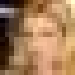

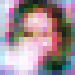

epoch =  115
Epoch [114/500], Step [438/438], d_loss: -1.3644, g_loss: 1.9166, D(x): -0.29, D(G(z)): -1.70


Epoch: 117: 100%|██████████| 438/438 [00:26<00:00, 16.74it/s, D_total_loss=-.944, G_loss=2.02, fake_score=-1.81, real_score=-.461]


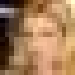

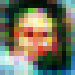

epoch =  117
Epoch [116/500], Step [438/438], d_loss: -0.9445, g_loss: 2.0168, D(x): -0.46, D(G(z)): -1.81


Epoch: 119: 100%|██████████| 438/438 [00:24<00:00, 17.84it/s, D_total_loss=-.773, G_loss=2.03, fake_score=-1.76, real_score=-.108]


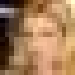

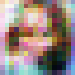

epoch =  119
Epoch [118/500], Step [438/438], d_loss: -0.7734, g_loss: 2.0267, D(x): -0.11, D(G(z)): -1.76


Epoch: 121: 100%|██████████| 438/438 [00:24<00:00, 17.92it/s, D_total_loss=-1.57, G_loss=1.63, fake_score=-1.8, real_score=-.0822]


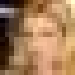

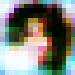

epoch =  121
Epoch [120/500], Step [438/438], d_loss: -1.5748, g_loss: 1.6275, D(x): -0.08, D(G(z)): -1.80


Epoch: 123: 100%|██████████| 438/438 [00:23<00:00, 18.25it/s, D_total_loss=-1.57, G_loss=1.5, fake_score=-1.68, real_score=-.0519]


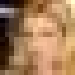

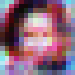

epoch =  123
Epoch [122/500], Step [438/438], d_loss: -1.5708, g_loss: 1.4984, D(x): -0.05, D(G(z)): -1.68


Epoch: 125: 100%|██████████| 438/438 [00:23<00:00, 18.52it/s, D_total_loss=-1.19, G_loss=1.69, fake_score=-1.81, real_score=-.241]


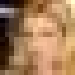

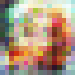

epoch =  125
Epoch [124/500], Step [438/438], d_loss: -1.1918, g_loss: 1.6855, D(x): -0.24, D(G(z)): -1.81


Epoch: 127: 100%|██████████| 438/438 [00:24<00:00, 18.02it/s, D_total_loss=-1.38, G_loss=1.39, fake_score=-1.57, real_score=-.116]


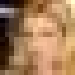

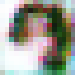

epoch =  127
Epoch [126/500], Step [438/438], d_loss: -1.3816, g_loss: 1.3927, D(x): -0.12, D(G(z)): -1.57


Epoch: 129: 100%|██████████| 438/438 [00:23<00:00, 18.61it/s, D_total_loss=-1.23, G_loss=1.45, fake_score=-1.3, real_score=0.176]


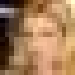

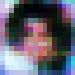

epoch =  129
Epoch [128/500], Step [438/438], d_loss: -1.2264, g_loss: 1.4475, D(x): 0.18, D(G(z)): -1.30


Epoch: 131: 100%|██████████| 438/438 [00:24<00:00, 18.22it/s, D_total_loss=-1.47, G_loss=1.42, fake_score=-1.38, real_score=0.148]


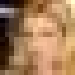

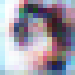

epoch =  131
Epoch [130/500], Step [438/438], d_loss: -1.4675, g_loss: 1.4213, D(x): 0.15, D(G(z)): -1.38


Epoch: 133: 100%|██████████| 438/438 [00:23<00:00, 18.26it/s, D_total_loss=-1.07, G_loss=1.31, fake_score=-1.44, real_score=0.159]


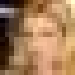

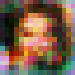

epoch =  133
Epoch [132/500], Step [438/438], d_loss: -1.0739, g_loss: 1.3119, D(x): 0.16, D(G(z)): -1.44


Epoch: 135: 100%|██████████| 438/438 [00:24<00:00, 18.07it/s, D_total_loss=-.496, G_loss=1.09, fake_score=-1.16, real_score=0.269]


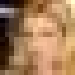

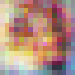

epoch =  135
Epoch [134/500], Step [438/438], d_loss: -0.4958, g_loss: 1.0884, D(x): 0.27, D(G(z)): -1.16


Epoch: 137: 100%|██████████| 438/438 [00:24<00:00, 17.90it/s, D_total_loss=-1.13, G_loss=1.07, fake_score=-1.12, real_score=0.213]


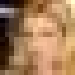

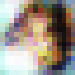

epoch =  137
Epoch [136/500], Step [438/438], d_loss: -1.1323, g_loss: 1.0740, D(x): 0.21, D(G(z)): -1.12


Epoch: 139: 100%|██████████| 438/438 [00:25<00:00, 17.48it/s, D_total_loss=-1.04, G_loss=1.19, fake_score=-1.23, real_score=0.207]


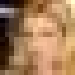

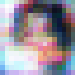

epoch =  139
Epoch [138/500], Step [438/438], d_loss: -1.0372, g_loss: 1.1877, D(x): 0.21, D(G(z)): -1.23


Epoch: 141: 100%|██████████| 438/438 [00:25<00:00, 17.08it/s, D_total_loss=-1.11, G_loss=1.19, fake_score=-1.15, real_score=0.306]


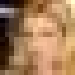

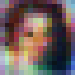

epoch =  141
Epoch [140/500], Step [438/438], d_loss: -1.1145, g_loss: 1.1873, D(x): 0.31, D(G(z)): -1.15


Epoch: 143: 100%|██████████| 438/438 [00:27<00:00, 16.20it/s, D_total_loss=-1.34, G_loss=1.03, fake_score=-1.18, real_score=0.468]


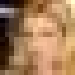

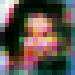

epoch =  143
Epoch [142/500], Step [438/438], d_loss: -1.3411, g_loss: 1.0342, D(x): 0.47, D(G(z)): -1.18


Epoch: 145: 100%|██████████| 438/438 [00:25<00:00, 17.47it/s, D_total_loss=-.208, G_loss=1.12, fake_score=-1.25, real_score=0.152]


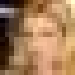

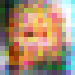

epoch =  145
Epoch [144/500], Step [438/438], d_loss: -0.2085, g_loss: 1.1167, D(x): 0.15, D(G(z)): -1.25


Epoch: 147: 100%|██████████| 438/438 [00:24<00:00, 17.89it/s, D_total_loss=-.588, G_loss=0.936, fake_score=-.848, real_score=0.0653]


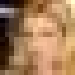

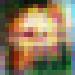

epoch =  147
Epoch [146/500], Step [438/438], d_loss: -0.5884, g_loss: 0.9362, D(x): 0.07, D(G(z)): -0.85


Epoch: 149: 100%|██████████| 438/438 [00:24<00:00, 17.80it/s, D_total_loss=-1.04, G_loss=1.14, fake_score=-.954, real_score=0.419]


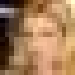

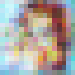

epoch =  149
Epoch [148/500], Step [438/438], d_loss: -1.0350, g_loss: 1.1395, D(x): 0.42, D(G(z)): -0.95


Epoch: 151: 100%|██████████| 438/438 [00:24<00:00, 17.87it/s, D_total_loss=-1.14, G_loss=1.03, fake_score=-.926, real_score=0.303]


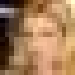

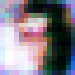

epoch =  151
Epoch [150/500], Step [438/438], d_loss: -1.1385, g_loss: 1.0301, D(x): 0.30, D(G(z)): -0.93


Epoch: 153: 100%|██████████| 438/438 [00:24<00:00, 18.04it/s, D_total_loss=-1.08, G_loss=0.963, fake_score=-.923, real_score=0.342]


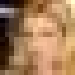

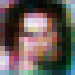

epoch =  153
Epoch [152/500], Step [438/438], d_loss: -1.0809, g_loss: 0.9626, D(x): 0.34, D(G(z)): -0.92


Epoch: 155: 100%|██████████| 438/438 [00:24<00:00, 17.62it/s, D_total_loss=-1.08, G_loss=0.824, fake_score=-.918, real_score=0.245]


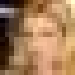

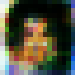

epoch =  155
Epoch [154/500], Step [438/438], d_loss: -1.0842, g_loss: 0.8238, D(x): 0.24, D(G(z)): -0.92


Epoch: 157: 100%|██████████| 438/438 [00:24<00:00, 17.89it/s, D_total_loss=-1.12, G_loss=0.933, fake_score=-1.27, real_score=0.235]


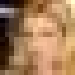

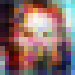

epoch =  157
Epoch [156/500], Step [438/438], d_loss: -1.1158, g_loss: 0.9331, D(x): 0.24, D(G(z)): -1.27


Epoch: 159: 100%|██████████| 438/438 [00:24<00:00, 17.63it/s, D_total_loss=1.81, G_loss=0.797, fake_score=-.89, real_score=0.387]


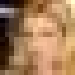

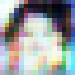

epoch =  159
Epoch [158/500], Step [438/438], d_loss: 1.8101, g_loss: 0.7972, D(x): 0.39, D(G(z)): -0.89


Epoch: 161: 100%|██████████| 438/438 [00:24<00:00, 18.08it/s, D_total_loss=-1.1, G_loss=0.818, fake_score=-.939, real_score=0.226]


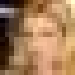

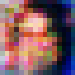

epoch =  161
Epoch [160/500], Step [438/438], d_loss: -1.0967, g_loss: 0.8181, D(x): 0.23, D(G(z)): -0.94


Epoch: 163: 100%|██████████| 438/438 [00:23<00:00, 18.41it/s, D_total_loss=-.907, G_loss=0.886, fake_score=-.775, real_score=0.268]


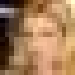

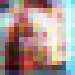

epoch =  163
Epoch [162/500], Step [438/438], d_loss: -0.9073, g_loss: 0.8860, D(x): 0.27, D(G(z)): -0.77


Epoch: 165: 100%|██████████| 438/438 [00:23<00:00, 18.58it/s, D_total_loss=-1.07, G_loss=0.926, fake_score=-.831, real_score=0.289]


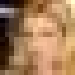

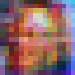

epoch =  165
Epoch [164/500], Step [438/438], d_loss: -1.0681, g_loss: 0.9263, D(x): 0.29, D(G(z)): -0.83


Epoch: 167: 100%|██████████| 438/438 [00:23<00:00, 18.34it/s, D_total_loss=-.996, G_loss=0.881, fake_score=-.776, real_score=0.306]


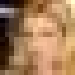

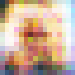

epoch =  167
Epoch [166/500], Step [438/438], d_loss: -0.9962, g_loss: 0.8811, D(x): 0.31, D(G(z)): -0.78


Epoch: 169: 100%|██████████| 438/438 [00:24<00:00, 17.75it/s, D_total_loss=-.561, G_loss=0.542, fake_score=-.44, real_score=0.242]


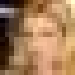

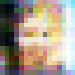

epoch =  169
Epoch [168/500], Step [438/438], d_loss: -0.5613, g_loss: 0.5422, D(x): 0.24, D(G(z)): -0.44


Epoch: 171: 100%|██████████| 438/438 [00:24<00:00, 17.93it/s, D_total_loss=-1.24, G_loss=0.719, fake_score=-.823, real_score=0.45]


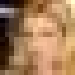

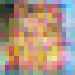

epoch =  171
Epoch [170/500], Step [438/438], d_loss: -1.2413, g_loss: 0.7187, D(x): 0.45, D(G(z)): -0.82


Epoch: 173: 100%|██████████| 438/438 [00:23<00:00, 18.34it/s, D_total_loss=-.668, G_loss=0.963, fake_score=-.662, real_score=0.25]


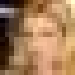

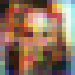

epoch =  173
Epoch [172/500], Step [438/438], d_loss: -0.6680, g_loss: 0.9632, D(x): 0.25, D(G(z)): -0.66


Epoch: 175: 100%|██████████| 438/438 [00:24<00:00, 17.93it/s, D_total_loss=-.772, G_loss=0.927, fake_score=-.75, real_score=0.134]


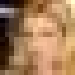

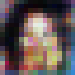

epoch =  175
Epoch [174/500], Step [438/438], d_loss: -0.7723, g_loss: 0.9270, D(x): 0.13, D(G(z)): -0.75


Epoch: 177: 100%|██████████| 438/438 [00:24<00:00, 17.63it/s, D_total_loss=-1.17, G_loss=0.909, fake_score=-1.1, real_score=0.295]


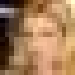

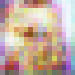

epoch =  177
Epoch [176/500], Step [438/438], d_loss: -1.1699, g_loss: 0.9087, D(x): 0.29, D(G(z)): -1.10


Epoch: 179: 100%|██████████| 438/438 [00:24<00:00, 18.06it/s, D_total_loss=-.911, G_loss=0.91, fake_score=-.837, real_score=0.121]


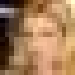

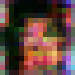

epoch =  179
Epoch [178/500], Step [438/438], d_loss: -0.9113, g_loss: 0.9096, D(x): 0.12, D(G(z)): -0.84


Epoch: 181: 100%|██████████| 438/438 [00:23<00:00, 18.65it/s, D_total_loss=-.927, G_loss=0.695, fake_score=-.654, real_score=0.324]


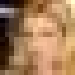

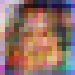

epoch =  181
Epoch [180/500], Step [438/438], d_loss: -0.9274, g_loss: 0.6948, D(x): 0.32, D(G(z)): -0.65


Epoch: 183: 100%|██████████| 438/438 [00:24<00:00, 18.17it/s, D_total_loss=-.0569, G_loss=0.761, fake_score=-.573, real_score=0.31]


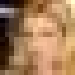

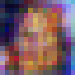

epoch =  183
Epoch [182/500], Step [438/438], d_loss: -0.0569, g_loss: 0.7610, D(x): 0.31, D(G(z)): -0.57


Epoch: 185: 100%|██████████| 438/438 [00:26<00:00, 16.70it/s, D_total_loss=-.844, G_loss=0.805, fake_score=-.855, real_score=0.0676]


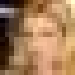

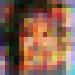

epoch =  185
Epoch [184/500], Step [438/438], d_loss: -0.8441, g_loss: 0.8048, D(x): 0.07, D(G(z)): -0.85


Epoch: 187: 100%|██████████| 438/438 [00:25<00:00, 17.06it/s, D_total_loss=-1.02, G_loss=0.721, fake_score=-.747, real_score=0.359]


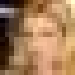

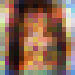

epoch =  187
Epoch [186/500], Step [438/438], d_loss: -1.0207, g_loss: 0.7208, D(x): 0.36, D(G(z)): -0.75


Epoch: 189: 100%|██████████| 438/438 [00:26<00:00, 16.60it/s, D_total_loss=0.396, G_loss=0.846, fake_score=-.909, real_score=0.254]


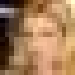

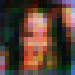

epoch =  189
Epoch [188/500], Step [438/438], d_loss: 0.3965, g_loss: 0.8463, D(x): 0.25, D(G(z)): -0.91


Epoch: 191: 100%|██████████| 438/438 [00:26<00:00, 16.50it/s, D_total_loss=-1.02, G_loss=0.761, fake_score=-1.09, real_score=0.313]


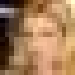

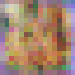

epoch =  191
Epoch [190/500], Step [438/438], d_loss: -1.0232, g_loss: 0.7614, D(x): 0.31, D(G(z)): -1.09


Epoch: 193: 100%|██████████| 438/438 [00:26<00:00, 16.78it/s, D_total_loss=-.844, G_loss=0.833, fake_score=-.958, real_score=0.322]


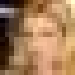

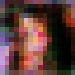

epoch =  193
Epoch [192/500], Step [438/438], d_loss: -0.8438, g_loss: 0.8326, D(x): 0.32, D(G(z)): -0.96


Epoch: 195: 100%|██████████| 438/438 [00:24<00:00, 17.83it/s, D_total_loss=-1.01, G_loss=0.844, fake_score=-.995, real_score=0.0734]


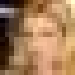

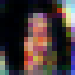

epoch =  195
Epoch [194/500], Step [438/438], d_loss: -1.0086, g_loss: 0.8435, D(x): 0.07, D(G(z)): -0.99


Epoch: 197: 100%|██████████| 438/438 [00:25<00:00, 17.18it/s, D_total_loss=-.33, G_loss=0.898, fake_score=-.72, real_score=-.0134]


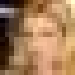

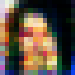

epoch =  197
Epoch [196/500], Step [438/438], d_loss: -0.3301, g_loss: 0.8975, D(x): -0.01, D(G(z)): -0.72


Epoch: 199: 100%|██████████| 438/438 [00:25<00:00, 17.12it/s, D_total_loss=0.0147, G_loss=0.801, fake_score=-.578, real_score=0.168]


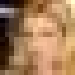

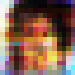

epoch =  199
Epoch [198/500], Step [438/438], d_loss: 0.0147, g_loss: 0.8009, D(x): 0.17, D(G(z)): -0.58


Epoch: 201: 100%|██████████| 438/438 [00:25<00:00, 17.34it/s, D_total_loss=-.523, G_loss=0.772, fake_score=-.539, real_score=0.247]


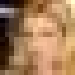

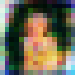

epoch =  201
Epoch [200/500], Step [438/438], d_loss: -0.5235, g_loss: 0.7718, D(x): 0.25, D(G(z)): -0.54


Epoch: 203: 100%|██████████| 438/438 [00:25<00:00, 17.02it/s, D_total_loss=-.261, G_loss=0.617, fake_score=-.676, real_score=-.0414]


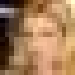

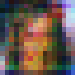

epoch =  203
Epoch [202/500], Step [438/438], d_loss: -0.2613, g_loss: 0.6172, D(x): -0.04, D(G(z)): -0.68


Epoch: 205: 100%|██████████| 438/438 [00:25<00:00, 17.09it/s, D_total_loss=-.478, G_loss=0.581, fake_score=-.761, real_score=0.0566]


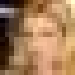

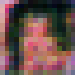

epoch =  205
Epoch [204/500], Step [438/438], d_loss: -0.4776, g_loss: 0.5806, D(x): 0.06, D(G(z)): -0.76


Epoch: 207: 100%|██████████| 438/438 [00:25<00:00, 17.39it/s, D_total_loss=0.621, G_loss=0.665, fake_score=-.45, real_score=0.0579]


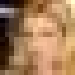

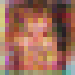

epoch =  207
Epoch [206/500], Step [438/438], d_loss: 0.6211, g_loss: 0.6653, D(x): 0.06, D(G(z)): -0.45


Epoch: 209: 100%|██████████| 438/438 [00:25<00:00, 17.40it/s, D_total_loss=-.615, G_loss=0.568, fake_score=-.66, real_score=0.117]


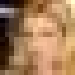

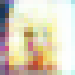

epoch =  209
Epoch [208/500], Step [438/438], d_loss: -0.6148, g_loss: 0.5682, D(x): 0.12, D(G(z)): -0.66


Epoch: 211: 100%|██████████| 438/438 [00:25<00:00, 17.50it/s, D_total_loss=-.887, G_loss=0.557, fake_score=-.774, real_score=0.24]


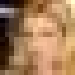

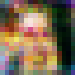

epoch =  211
Epoch [210/500], Step [438/438], d_loss: -0.8872, g_loss: 0.5575, D(x): 0.24, D(G(z)): -0.77


Epoch: 213: 100%|██████████| 438/438 [00:24<00:00, 17.60it/s, D_total_loss=-.647, G_loss=0.765, fake_score=-.597, real_score=0.143]


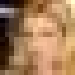

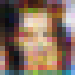

epoch =  213
Epoch [212/500], Step [438/438], d_loss: -0.6468, g_loss: 0.7654, D(x): 0.14, D(G(z)): -0.60


Epoch: 215: 100%|██████████| 438/438 [00:26<00:00, 16.81it/s, D_total_loss=-.739, G_loss=0.564, fake_score=-.881, real_score=-.000493]


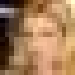

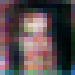

epoch =  215
Epoch [214/500], Step [438/438], d_loss: -0.7386, g_loss: 0.5638, D(x): -0.00, D(G(z)): -0.88


Epoch: 217: 100%|██████████| 438/438 [00:26<00:00, 16.77it/s, D_total_loss=-.702, G_loss=0.775, fake_score=-.526, real_score=0.234]


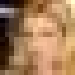

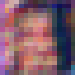

epoch =  217
Epoch [216/500], Step [438/438], d_loss: -0.7018, g_loss: 0.7752, D(x): 0.23, D(G(z)): -0.53


Epoch: 219: 100%|██████████| 438/438 [00:26<00:00, 16.49it/s, D_total_loss=-.648, G_loss=0.473, fake_score=-.624, real_score=0.113]


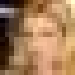

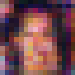

epoch =  219
Epoch [218/500], Step [438/438], d_loss: -0.6484, g_loss: 0.4732, D(x): 0.11, D(G(z)): -0.62


Epoch: 221: 100%|██████████| 438/438 [00:26<00:00, 16.40it/s, D_total_loss=-.638, G_loss=0.662, fake_score=-.623, real_score=0.0756]


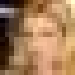

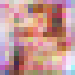

epoch =  221
Epoch [220/500], Step [438/438], d_loss: -0.6376, g_loss: 0.6625, D(x): 0.08, D(G(z)): -0.62


Epoch: 223: 100%|██████████| 438/438 [00:25<00:00, 17.13it/s, D_total_loss=-.255, G_loss=0.614, fake_score=-.363, real_score=0.368]


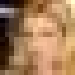

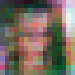

epoch =  223
Epoch [222/500], Step [438/438], d_loss: -0.2554, g_loss: 0.6142, D(x): 0.37, D(G(z)): -0.36


Epoch: 225: 100%|██████████| 438/438 [00:25<00:00, 17.40it/s, D_total_loss=-.106, G_loss=0.744, fake_score=-.751, real_score=-.0364]


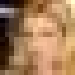

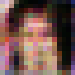

epoch =  225
Epoch [224/500], Step [438/438], d_loss: -0.1057, g_loss: 0.7443, D(x): -0.04, D(G(z)): -0.75


Epoch: 227: 100%|██████████| 438/438 [00:26<00:00, 16.73it/s, D_total_loss=-.442, G_loss=0.552, fake_score=-.527, real_score=0.00259]


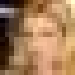

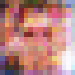

epoch =  227
Epoch [226/500], Step [438/438], d_loss: -0.4424, g_loss: 0.5520, D(x): 0.00, D(G(z)): -0.53


Epoch: 229: 100%|██████████| 438/438 [00:26<00:00, 16.77it/s, D_total_loss=-.728, G_loss=0.388, fake_score=-.547, real_score=0.314]


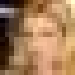

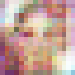

epoch =  229
Epoch [228/500], Step [438/438], d_loss: -0.7279, g_loss: 0.3878, D(x): 0.31, D(G(z)): -0.55


Epoch: 231: 100%|██████████| 438/438 [00:26<00:00, 16.29it/s, D_total_loss=-.277, G_loss=0.397, fake_score=-.592, real_score=0.184]


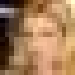

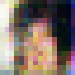

epoch =  231
Epoch [230/500], Step [438/438], d_loss: -0.2767, g_loss: 0.3971, D(x): 0.18, D(G(z)): -0.59


Epoch: 233: 100%|██████████| 438/438 [00:26<00:00, 16.76it/s, D_total_loss=0.0857, G_loss=0.531, fake_score=-.192, real_score=0.0489]


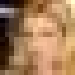

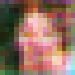

epoch =  233
Epoch [232/500], Step [438/438], d_loss: 0.0857, g_loss: 0.5312, D(x): 0.05, D(G(z)): -0.19


Epoch: 235: 100%|██████████| 438/438 [00:27<00:00, 16.14it/s, D_total_loss=-.575, G_loss=0.605, fake_score=-.477, real_score=0.186]


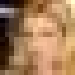

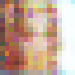

epoch =  235
Epoch [234/500], Step [438/438], d_loss: -0.5753, g_loss: 0.6053, D(x): 0.19, D(G(z)): -0.48


Epoch: 237: 100%|██████████| 438/438 [00:29<00:00, 15.09it/s, D_total_loss=-.121, G_loss=0.317, fake_score=-.462, real_score=0.000855]


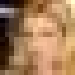

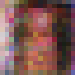

epoch =  237
Epoch [236/500], Step [438/438], d_loss: -0.1214, g_loss: 0.3169, D(x): 0.00, D(G(z)): -0.46


Epoch: 239: 100%|██████████| 438/438 [00:26<00:00, 16.37it/s, D_total_loss=-.316, G_loss=0.277, fake_score=-.403, real_score=0.185]


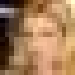

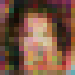

epoch =  239
Epoch [238/500], Step [438/438], d_loss: -0.3163, g_loss: 0.2767, D(x): 0.19, D(G(z)): -0.40


Epoch: 241: 100%|██████████| 438/438 [00:26<00:00, 16.84it/s, D_total_loss=-.432, G_loss=0.426, fake_score=-.412, real_score=0.0672]


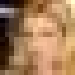

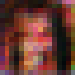

epoch =  241
Epoch [240/500], Step [438/438], d_loss: -0.4322, g_loss: 0.4256, D(x): 0.07, D(G(z)): -0.41


Epoch: 243: 100%|██████████| 438/438 [00:25<00:00, 16.94it/s, D_total_loss=0.403, G_loss=0.406, fake_score=-.165, real_score=-.0744]


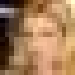

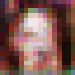

epoch =  243
Epoch [242/500], Step [438/438], d_loss: 0.4025, g_loss: 0.4061, D(x): -0.07, D(G(z)): -0.16


Epoch: 245: 100%|██████████| 438/438 [00:26<00:00, 16.47it/s, D_total_loss=-.333, G_loss=0.432, fake_score=-.351, real_score=0.0545]


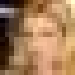

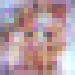

epoch =  245
Epoch [244/500], Step [438/438], d_loss: -0.3332, g_loss: 0.4315, D(x): 0.05, D(G(z)): -0.35


Epoch: 247: 100%|██████████| 438/438 [00:25<00:00, 17.22it/s, D_total_loss=-.111, G_loss=0.425, fake_score=-.378, real_score=-.042]


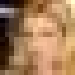

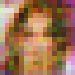

epoch =  247
Epoch [246/500], Step [438/438], d_loss: -0.1105, g_loss: 0.4250, D(x): -0.04, D(G(z)): -0.38


Epoch: 249: 100%|██████████| 438/438 [00:26<00:00, 16.74it/s, D_total_loss=0.193, G_loss=0.388, fake_score=-.518, real_score=0.0357]


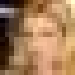

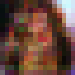

epoch =  249
Epoch [248/500], Step [438/438], d_loss: 0.1933, g_loss: 0.3877, D(x): 0.04, D(G(z)): -0.52


Epoch: 251: 100%|██████████| 438/438 [00:26<00:00, 16.71it/s, D_total_loss=-.629, G_loss=0.253, fake_score=-.339, real_score=0.496]


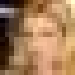

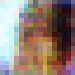

epoch =  251
Epoch [250/500], Step [438/438], d_loss: -0.6288, g_loss: 0.2535, D(x): 0.50, D(G(z)): -0.34


Epoch: 253: 100%|██████████| 438/438 [00:24<00:00, 17.65it/s, D_total_loss=-.154, G_loss=0.243, fake_score=-.425, real_score=0.303]


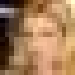

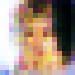

epoch =  253
Epoch [252/500], Step [438/438], d_loss: -0.1542, g_loss: 0.2430, D(x): 0.30, D(G(z)): -0.43


Epoch: 255: 100%|██████████| 438/438 [00:23<00:00, 18.82it/s, D_total_loss=-.602, G_loss=0.447, fake_score=-.643, real_score=0.0116]


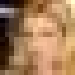

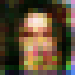

epoch =  255
Epoch [254/500], Step [438/438], d_loss: -0.6017, g_loss: 0.4470, D(x): 0.01, D(G(z)): -0.64


Epoch: 257: 100%|██████████| 438/438 [00:22<00:00, 19.47it/s, D_total_loss=-.571, G_loss=0.415, fake_score=-.408, real_score=0.272]


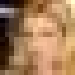

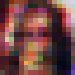

epoch =  257
Epoch [256/500], Step [438/438], d_loss: -0.5711, g_loss: 0.4148, D(x): 0.27, D(G(z)): -0.41


Epoch: 259: 100%|██████████| 438/438 [00:22<00:00, 19.42it/s, D_total_loss=-.576, G_loss=0.289, fake_score=-.526, real_score=0.149]


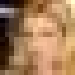

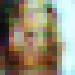

epoch =  259
Epoch [258/500], Step [438/438], d_loss: -0.5764, g_loss: 0.2889, D(x): 0.15, D(G(z)): -0.53


Epoch: 261: 100%|██████████| 438/438 [00:22<00:00, 19.32it/s, D_total_loss=1.69, G_loss=0.494, fake_score=-.372, real_score=0.103]


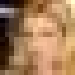

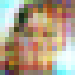

epoch =  261
Epoch [260/500], Step [438/438], d_loss: 1.6946, g_loss: 0.4940, D(x): 0.10, D(G(z)): -0.37


Epoch: 263: 100%|██████████| 438/438 [00:22<00:00, 19.51it/s, D_total_loss=0.353, G_loss=0.389, fake_score=-.473, real_score=-.0452]


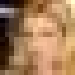

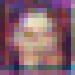

epoch =  263
Epoch [262/500], Step [438/438], d_loss: 0.3529, g_loss: 0.3888, D(x): -0.05, D(G(z)): -0.47


Epoch: 265: 100%|██████████| 438/438 [00:23<00:00, 18.86it/s, D_total_loss=0.151, G_loss=0.386, fake_score=-.232, real_score=0.142]


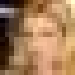

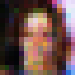

epoch =  265
Epoch [264/500], Step [438/438], d_loss: 0.1507, g_loss: 0.3861, D(x): 0.14, D(G(z)): -0.23


Epoch: 267: 100%|██████████| 438/438 [00:22<00:00, 19.44it/s, D_total_loss=-.809, G_loss=0.288, fake_score=-.404, real_score=0.464]


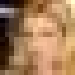

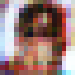

epoch =  267
Epoch [266/500], Step [438/438], d_loss: -0.8086, g_loss: 0.2876, D(x): 0.46, D(G(z)): -0.40


Epoch: 269: 100%|██████████| 438/438 [00:22<00:00, 19.45it/s, D_total_loss=-.315, G_loss=0.312, fake_score=-.126, real_score=0.225]


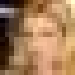

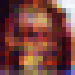

epoch =  269
Epoch [268/500], Step [438/438], d_loss: -0.3149, g_loss: 0.3123, D(x): 0.22, D(G(z)): -0.13


Epoch: 271: 100%|██████████| 438/438 [00:22<00:00, 19.48it/s, D_total_loss=-.63, G_loss=0.372, fake_score=-.453, real_score=0.253]


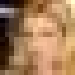

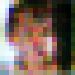

epoch =  271
Epoch [270/500], Step [438/438], d_loss: -0.6295, g_loss: 0.3718, D(x): 0.25, D(G(z)): -0.45


Epoch: 273: 100%|██████████| 438/438 [00:22<00:00, 19.23it/s, D_total_loss=-.254, G_loss=0.347, fake_score=-.208, real_score=0.0961]


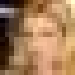

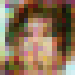

epoch =  273
Epoch [272/500], Step [438/438], d_loss: -0.2537, g_loss: 0.3465, D(x): 0.10, D(G(z)): -0.21


Epoch: 275: 100%|██████████| 438/438 [00:22<00:00, 19.29it/s, D_total_loss=-.352, G_loss=0.375, fake_score=-.368, real_score=0.1]


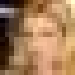

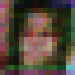

epoch =  275
Epoch [274/500], Step [438/438], d_loss: -0.3518, g_loss: 0.3748, D(x): 0.10, D(G(z)): -0.37


Epoch: 277: 100%|██████████| 438/438 [00:22<00:00, 19.25it/s, D_total_loss=-.159, G_loss=0.22, fake_score=-.132, real_score=0.0626]


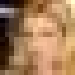

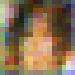

epoch =  277
Epoch [276/500], Step [438/438], d_loss: -0.1588, g_loss: 0.2198, D(x): 0.06, D(G(z)): -0.13


Epoch: 279: 100%|██████████| 438/438 [00:22<00:00, 19.09it/s, D_total_loss=-.214, G_loss=0.366, fake_score=-.389, real_score=0.153]


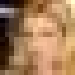

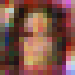

epoch =  279
Epoch [278/500], Step [438/438], d_loss: -0.2135, g_loss: 0.3660, D(x): 0.15, D(G(z)): -0.39


Epoch: 281: 100%|██████████| 438/438 [00:23<00:00, 18.91it/s, D_total_loss=-.292, G_loss=0.313, fake_score=-.394, real_score=0.103]


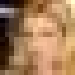

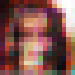

epoch =  281
Epoch [280/500], Step [438/438], d_loss: -0.2916, g_loss: 0.3128, D(x): 0.10, D(G(z)): -0.39


Epoch: 283: 100%|██████████| 438/438 [00:22<00:00, 19.14it/s, D_total_loss=-.438, G_loss=0.444, fake_score=-.31, real_score=0.222]


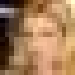

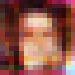

epoch =  283
Epoch [282/500], Step [438/438], d_loss: -0.4378, g_loss: 0.4445, D(x): 0.22, D(G(z)): -0.31


Epoch: 285: 100%|██████████| 438/438 [00:22<00:00, 19.13it/s, D_total_loss=-.362, G_loss=0.303, fake_score=-.35, real_score=0.184]


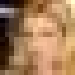

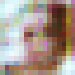

epoch =  285
Epoch [284/500], Step [438/438], d_loss: -0.3619, g_loss: 0.3034, D(x): 0.18, D(G(z)): -0.35


Epoch: 287: 100%|██████████| 438/438 [00:23<00:00, 18.93it/s, D_total_loss=-.446, G_loss=0.218, fake_score=-.598, real_score=0.0102]


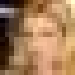

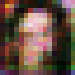

epoch =  287
Epoch [286/500], Step [438/438], d_loss: -0.4462, g_loss: 0.2184, D(x): 0.01, D(G(z)): -0.60


Epoch: 289: 100%|██████████| 438/438 [00:23<00:00, 18.87it/s, D_total_loss=-.15, G_loss=0.207, fake_score=-.254, real_score=0.208]


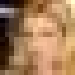

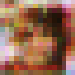

epoch =  289
Epoch [288/500], Step [438/438], d_loss: -0.1498, g_loss: 0.2071, D(x): 0.21, D(G(z)): -0.25


Epoch: 291: 100%|██████████| 438/438 [00:22<00:00, 19.05it/s, D_total_loss=-.173, G_loss=0.2, fake_score=-.178, real_score=0.107]


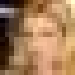

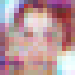

epoch =  291
Epoch [290/500], Step [438/438], d_loss: -0.1731, g_loss: 0.2004, D(x): 0.11, D(G(z)): -0.18


Epoch: 293: 100%|██████████| 438/438 [00:22<00:00, 19.21it/s, D_total_loss=-.367, G_loss=0.28, fake_score=-.188, real_score=0.236]


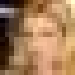

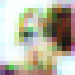

epoch =  293
Epoch [292/500], Step [438/438], d_loss: -0.3671, g_loss: 0.2802, D(x): 0.24, D(G(z)): -0.19


Epoch: 295: 100%|██████████| 438/438 [00:23<00:00, 18.85it/s, D_total_loss=-.165, G_loss=0.0287, fake_score=0.00539, real_score=0.243]


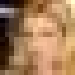

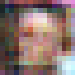

epoch =  295
Epoch [294/500], Step [438/438], d_loss: -0.1647, g_loss: 0.0287, D(x): 0.24, D(G(z)): 0.01


Epoch: 297: 100%|██████████| 438/438 [00:23<00:00, 18.87it/s, D_total_loss=-.363, G_loss=0.16, fake_score=-.163, real_score=0.261]


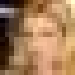

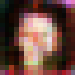

epoch =  297
Epoch [296/500], Step [438/438], d_loss: -0.3635, g_loss: 0.1595, D(x): 0.26, D(G(z)): -0.16


Epoch: 299: 100%|██████████| 438/438 [00:23<00:00, 18.42it/s, D_total_loss=-.447, G_loss=0.0694, fake_score=-.123, real_score=0.405]


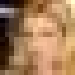

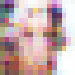

epoch =  299
Epoch [298/500], Step [438/438], d_loss: -0.4471, g_loss: 0.0694, D(x): 0.41, D(G(z)): -0.12


Epoch: 301: 100%|██████████| 438/438 [00:23<00:00, 18.98it/s, D_total_loss=-.403, G_loss=0.101, fake_score=-.125, real_score=0.351]


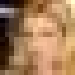

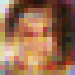

epoch =  301
Epoch [300/500], Step [438/438], d_loss: -0.4027, g_loss: 0.1011, D(x): 0.35, D(G(z)): -0.12


Epoch: 303: 100%|██████████| 438/438 [00:23<00:00, 18.79it/s, D_total_loss=0.00738, G_loss=0.169, fake_score=-.0808, real_score=0.191]


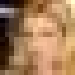

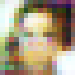

epoch =  303
Epoch [302/500], Step [438/438], d_loss: 0.0074, g_loss: 0.1692, D(x): 0.19, D(G(z)): -0.08


Epoch: 305: 100%|██████████| 438/438 [00:23<00:00, 18.66it/s, D_total_loss=-.744, G_loss=0.254, fake_score=-.293, real_score=0.478]


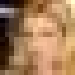

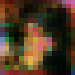

epoch =  305
Epoch [304/500], Step [438/438], d_loss: -0.7436, g_loss: 0.2538, D(x): 0.48, D(G(z)): -0.29


Epoch: 307: 100%|██████████| 438/438 [00:23<00:00, 18.82it/s, D_total_loss=-.163, G_loss=0.255, fake_score=-.0567, real_score=0.206]


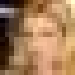

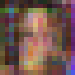

epoch =  307
Epoch [306/500], Step [438/438], d_loss: -0.1630, g_loss: 0.2552, D(x): 0.21, D(G(z)): -0.06


Epoch: 309: 100%|██████████| 438/438 [00:23<00:00, 18.60it/s, D_total_loss=-.291, G_loss=0.0639, fake_score=-.208, real_score=0.156]


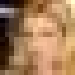

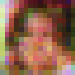

epoch =  309
Epoch [308/500], Step [438/438], d_loss: -0.2907, g_loss: 0.0639, D(x): 0.16, D(G(z)): -0.21


Epoch: 311: 100%|██████████| 438/438 [00:23<00:00, 18.72it/s, D_total_loss=-.181, G_loss=-.0121, fake_score=-.123, real_score=0.192]


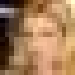

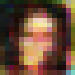

epoch =  311
Epoch [310/500], Step [438/438], d_loss: -0.1806, g_loss: -0.0121, D(x): 0.19, D(G(z)): -0.12


Epoch: 313: 100%|██████████| 438/438 [00:23<00:00, 18.46it/s, D_total_loss=-.205, G_loss=0.124, fake_score=0.02, real_score=0.273]


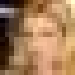

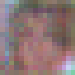

epoch =  313
Epoch [312/500], Step [438/438], d_loss: -0.2045, g_loss: 0.1240, D(x): 0.27, D(G(z)): 0.02


Epoch: 315: 100%|██████████| 438/438 [00:23<00:00, 18.92it/s, D_total_loss=0.106, G_loss=-.257, fake_score=-.111, real_score=0.209]


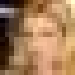

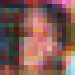

epoch =  315
Epoch [314/500], Step [438/438], d_loss: 0.1063, g_loss: -0.2572, D(x): 0.21, D(G(z)): -0.11


Epoch: 317: 100%|██████████| 438/438 [00:23<00:00, 18.51it/s, D_total_loss=0.166, G_loss=-.0488, fake_score=0.0377, real_score=0.286]


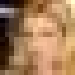

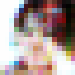

epoch =  317
Epoch [316/500], Step [438/438], d_loss: 0.1663, g_loss: -0.0488, D(x): 0.29, D(G(z)): 0.04


Epoch: 319: 100%|██████████| 438/438 [00:23<00:00, 18.55it/s, D_total_loss=0.917, G_loss=0.0796, fake_score=-.104, real_score=0.165]


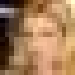

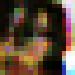

epoch =  319
Epoch [318/500], Step [438/438], d_loss: 0.9165, g_loss: 0.0796, D(x): 0.16, D(G(z)): -0.10


Epoch: 321: 100%|██████████| 438/438 [00:23<00:00, 18.89it/s, D_total_loss=-.155, G_loss=0.0786, fake_score=0.0298, real_score=0.411]


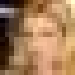

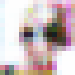

epoch =  321
Epoch [320/500], Step [438/438], d_loss: -0.1546, g_loss: 0.0786, D(x): 0.41, D(G(z)): 0.03


Epoch: 323: 100%|██████████| 438/438 [00:23<00:00, 18.57it/s, D_total_loss=-.0422, G_loss=0.109, fake_score=0.188, real_score=0.319]


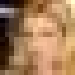

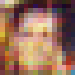

epoch =  323
Epoch [322/500], Step [438/438], d_loss: -0.0422, g_loss: 0.1087, D(x): 0.32, D(G(z)): 0.19


Epoch: 325: 100%|██████████| 438/438 [00:23<00:00, 18.67it/s, D_total_loss=-.371, G_loss=0.126, fake_score=-.162, real_score=0.284]


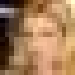

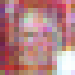

epoch =  325
Epoch [324/500], Step [438/438], d_loss: -0.3707, g_loss: 0.1261, D(x): 0.28, D(G(z)): -0.16


Epoch: 327: 100%|██████████| 438/438 [00:23<00:00, 18.68it/s, D_total_loss=-.195, G_loss=-.12, fake_score=-.194, real_score=0.259]


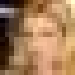

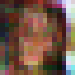

epoch =  327
Epoch [326/500], Step [438/438], d_loss: -0.1947, g_loss: -0.1196, D(x): 0.26, D(G(z)): -0.19


Epoch: 329: 100%|██████████| 438/438 [00:23<00:00, 18.66it/s, D_total_loss=-.328, G_loss=-.0942, fake_score=-.0921, real_score=0.395]


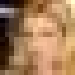

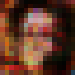

epoch =  329
Epoch [328/500], Step [438/438], d_loss: -0.3282, g_loss: -0.0942, D(x): 0.39, D(G(z)): -0.09


Epoch: 331: 100%|██████████| 438/438 [00:23<00:00, 18.44it/s, D_total_loss=-.13, G_loss=0.104, fake_score=-.0379, real_score=0.164]


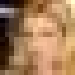

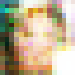

epoch =  331
Epoch [330/500], Step [438/438], d_loss: -0.1304, g_loss: 0.1042, D(x): 0.16, D(G(z)): -0.04


Epoch: 333: 100%|██████████| 438/438 [00:24<00:00, 18.20it/s, D_total_loss=-.351, G_loss=-.0471, fake_score=-.0333, real_score=0.433]


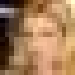

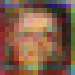

epoch =  333
Epoch [332/500], Step [438/438], d_loss: -0.3514, g_loss: -0.0471, D(x): 0.43, D(G(z)): -0.03


Epoch: 335: 100%|██████████| 438/438 [00:23<00:00, 18.58it/s, D_total_loss=-.285, G_loss=-.101, fake_score=0.0557, real_score=0.371]


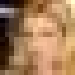

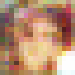

epoch =  335
Epoch [334/500], Step [438/438], d_loss: -0.2852, g_loss: -0.1006, D(x): 0.37, D(G(z)): 0.06


Epoch: 337: 100%|██████████| 438/438 [00:23<00:00, 18.83it/s, D_total_loss=-.328, G_loss=-.176, fake_score=-.029, real_score=0.341]


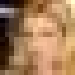

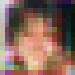

epoch =  337
Epoch [336/500], Step [438/438], d_loss: -0.3283, g_loss: -0.1755, D(x): 0.34, D(G(z)): -0.03


Epoch: 339: 100%|██████████| 438/438 [00:23<00:00, 18.33it/s, D_total_loss=-.236, G_loss=-.0434, fake_score=-.0318, real_score=0.261]


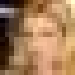

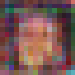

epoch =  339
Epoch [338/500], Step [438/438], d_loss: -0.2359, g_loss: -0.0434, D(x): 0.26, D(G(z)): -0.03


Epoch: 341: 100%|██████████| 438/438 [00:23<00:00, 18.32it/s, D_total_loss=-.25, G_loss=0.0381, fake_score=0.0831, real_score=0.416]


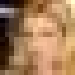

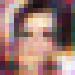

epoch =  341
Epoch [340/500], Step [438/438], d_loss: -0.2503, g_loss: 0.0381, D(x): 0.42, D(G(z)): 0.08


Epoch: 343: 100%|██████████| 438/438 [00:23<00:00, 18.55it/s, D_total_loss=-.209, G_loss=-.165, fake_score=0.103, real_score=0.365]


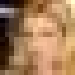

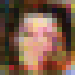

epoch =  343
Epoch [342/500], Step [438/438], d_loss: -0.2087, g_loss: -0.1653, D(x): 0.37, D(G(z)): 0.10


Epoch: 345: 100%|██████████| 438/438 [00:23<00:00, 18.62it/s, D_total_loss=-.094, G_loss=0.00192, fake_score=0.0891, real_score=0.284]


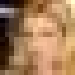

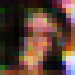

epoch =  345
Epoch [344/500], Step [438/438], d_loss: -0.0940, g_loss: 0.0019, D(x): 0.28, D(G(z)): 0.09


Epoch: 347: 100%|██████████| 438/438 [00:23<00:00, 18.36it/s, D_total_loss=-.206, G_loss=-.201, fake_score=0.188, real_score=0.471]


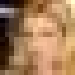

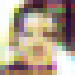

epoch =  347
Epoch [346/500], Step [438/438], d_loss: -0.2061, g_loss: -0.2013, D(x): 0.47, D(G(z)): 0.19


Epoch: 349: 100%|██████████| 438/438 [00:24<00:00, 18.10it/s, D_total_loss=-.159, G_loss=-.174, fake_score=0.0867, real_score=0.334]


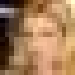

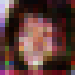

epoch =  349
Epoch [348/500], Step [438/438], d_loss: -0.1593, g_loss: -0.1739, D(x): 0.33, D(G(z)): 0.09


Epoch: 351: 100%|██████████| 438/438 [00:24<00:00, 18.20it/s, D_total_loss=-.16, G_loss=0.0313, fake_score=0.276, real_score=0.508]


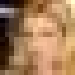

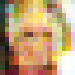

epoch =  351
Epoch [350/500], Step [438/438], d_loss: -0.1598, g_loss: 0.0313, D(x): 0.51, D(G(z)): 0.28


Epoch: 353: 100%|██████████| 438/438 [00:23<00:00, 18.25it/s, D_total_loss=1.04, G_loss=-.0136, fake_score=0.357, real_score=0.286]


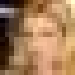

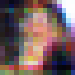

epoch =  353
Epoch [352/500], Step [438/438], d_loss: 1.0447, g_loss: -0.0136, D(x): 0.29, D(G(z)): 0.36


Epoch: 355: 100%|██████████| 438/438 [00:24<00:00, 18.22it/s, D_total_loss=-.34, G_loss=-.185, fake_score=0.0863, real_score=0.487]


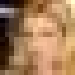

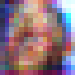

epoch =  355
Epoch [354/500], Step [438/438], d_loss: -0.3402, g_loss: -0.1849, D(x): 0.49, D(G(z)): 0.09


Epoch: 357: 100%|██████████| 438/438 [00:24<00:00, 18.07it/s, D_total_loss=0.0663, G_loss=-.238, fake_score=0.256, real_score=0.305]


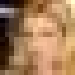

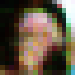

epoch =  357
Epoch [356/500], Step [438/438], d_loss: 0.0663, g_loss: -0.2384, D(x): 0.31, D(G(z)): 0.26


Epoch: 359: 100%|██████████| 438/438 [00:23<00:00, 18.27it/s, D_total_loss=0.0325, G_loss=-.147, fake_score=0.0237, real_score=0.264]


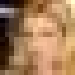

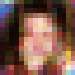

epoch =  359
Epoch [358/500], Step [438/438], d_loss: 0.0325, g_loss: -0.1469, D(x): 0.26, D(G(z)): 0.02


Epoch: 361: 100%|██████████| 438/438 [00:24<00:00, 18.16it/s, D_total_loss=0.777, G_loss=-.166, fake_score=0.251, real_score=0.434]


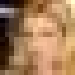

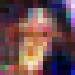

epoch =  361
Epoch [360/500], Step [438/438], d_loss: 0.7774, g_loss: -0.1660, D(x): 0.43, D(G(z)): 0.25


Epoch: 363: 100%|██████████| 438/438 [00:24<00:00, 18.11it/s, D_total_loss=-.247, G_loss=-.177, fake_score=-.114, real_score=0.295]


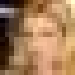

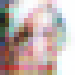

epoch =  363
Epoch [362/500], Step [438/438], d_loss: -0.2471, g_loss: -0.1766, D(x): 0.30, D(G(z)): -0.11


Epoch: 365: 100%|██████████| 438/438 [00:23<00:00, 18.32it/s, D_total_loss=-.048, G_loss=-.0361, fake_score=0.106, real_score=0.269]


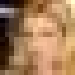

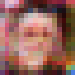

epoch =  365
Epoch [364/500], Step [438/438], d_loss: -0.0480, g_loss: -0.0361, D(x): 0.27, D(G(z)): 0.11


Epoch: 367: 100%|██████████| 438/438 [00:24<00:00, 18.06it/s, D_total_loss=-.096, G_loss=-.0754, fake_score=0.169, real_score=0.321]


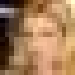

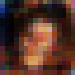

epoch =  367
Epoch [366/500], Step [438/438], d_loss: -0.0960, g_loss: -0.0754, D(x): 0.32, D(G(z)): 0.17


Epoch: 369: 100%|██████████| 438/438 [00:24<00:00, 18.11it/s, D_total_loss=0.864, G_loss=-.205, fake_score=0.0982, real_score=0.214]


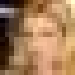

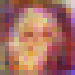

epoch =  369
Epoch [368/500], Step [438/438], d_loss: 0.8643, g_loss: -0.2050, D(x): 0.21, D(G(z)): 0.10


Epoch: 371: 100%|██████████| 438/438 [00:23<00:00, 18.39it/s, D_total_loss=-.253, G_loss=-.154, fake_score=0.165, real_score=0.526]


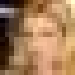

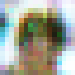

epoch =  371
Epoch [370/500], Step [438/438], d_loss: -0.2531, g_loss: -0.1543, D(x): 0.53, D(G(z)): 0.17


Epoch: 373: 100%|██████████| 438/438 [00:24<00:00, 18.13it/s, D_total_loss=0.661, G_loss=-.319, fake_score=-.115, real_score=0.0671]


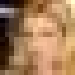

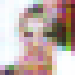

epoch =  373
Epoch [372/500], Step [438/438], d_loss: 0.6610, g_loss: -0.3191, D(x): 0.07, D(G(z)): -0.12


Epoch: 375: 100%|██████████| 438/438 [00:23<00:00, 18.25it/s, D_total_loss=0.0793, G_loss=-.204, fake_score=0.18, real_score=0.432]


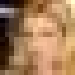

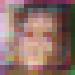

epoch =  375
Epoch [374/500], Step [438/438], d_loss: 0.0793, g_loss: -0.2040, D(x): 0.43, D(G(z)): 0.18


Epoch: 377: 100%|██████████| 438/438 [00:24<00:00, 18.05it/s, D_total_loss=-.153, G_loss=-.254, fake_score=0.198, real_score=0.43]


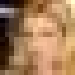

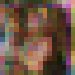

epoch =  377
Epoch [376/500], Step [438/438], d_loss: -0.1525, g_loss: -0.2543, D(x): 0.43, D(G(z)): 0.20


Epoch: 379: 100%|██████████| 438/438 [00:24<00:00, 17.99it/s, D_total_loss=-.253, G_loss=-.311, fake_score=0.17, real_score=0.75]


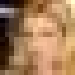

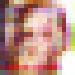

epoch =  379
Epoch [378/500], Step [438/438], d_loss: -0.2531, g_loss: -0.3111, D(x): 0.75, D(G(z)): 0.17


Epoch: 381: 100%|██████████| 438/438 [00:24<00:00, 18.20it/s, D_total_loss=-.213, G_loss=-.157, fake_score=0.161, real_score=0.41]


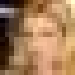

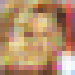

epoch =  381
Epoch [380/500], Step [438/438], d_loss: -0.2130, g_loss: -0.1571, D(x): 0.41, D(G(z)): 0.16


Epoch: 383: 100%|██████████| 438/438 [00:24<00:00, 17.90it/s, D_total_loss=-.286, G_loss=-.223, fake_score=0.0546, real_score=0.458]


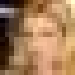

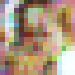

epoch =  383
Epoch [382/500], Step [438/438], d_loss: -0.2859, g_loss: -0.2229, D(x): 0.46, D(G(z)): 0.05


Epoch: 385: 100%|██████████| 438/438 [00:24<00:00, 18.15it/s, D_total_loss=-.207, G_loss=-.232, fake_score=0.201, real_score=0.45]


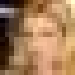

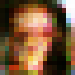

epoch =  385
Epoch [384/500], Step [438/438], d_loss: -0.2069, g_loss: -0.2323, D(x): 0.45, D(G(z)): 0.20


Epoch: 387: 100%|██████████| 438/438 [00:24<00:00, 17.85it/s, D_total_loss=0.0372, G_loss=-.313, fake_score=0.235, real_score=0.551]


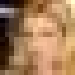

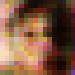

epoch =  387
Epoch [386/500], Step [438/438], d_loss: 0.0372, g_loss: -0.3126, D(x): 0.55, D(G(z)): 0.23


Epoch: 389: 100%|██████████| 438/438 [00:24<00:00, 17.86it/s, D_total_loss=0.352, G_loss=-.363, fake_score=0.225, real_score=0.555]


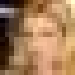

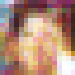

epoch =  389
Epoch [388/500], Step [438/438], d_loss: 0.3518, g_loss: -0.3635, D(x): 0.56, D(G(z)): 0.22


Epoch: 391: 100%|██████████| 438/438 [00:24<00:00, 18.04it/s, D_total_loss=-.242, G_loss=-.207, fake_score=0.178, real_score=0.458]


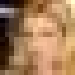

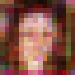

epoch =  391
Epoch [390/500], Step [438/438], d_loss: -0.2423, g_loss: -0.2068, D(x): 0.46, D(G(z)): 0.18


Epoch: 393: 100%|██████████| 438/438 [00:24<00:00, 17.86it/s, D_total_loss=2.74, G_loss=-.325, fake_score=0.261, real_score=0.515]


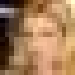

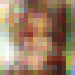

epoch =  393
Epoch [392/500], Step [438/438], d_loss: 2.7375, g_loss: -0.3251, D(x): 0.52, D(G(z)): 0.26


Epoch: 395: 100%|██████████| 438/438 [00:24<00:00, 17.69it/s, D_total_loss=-.0522, G_loss=-.301, fake_score=0.309, real_score=0.44]


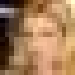

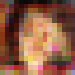

epoch =  395
Epoch [394/500], Step [438/438], d_loss: -0.0522, g_loss: -0.3009, D(x): 0.44, D(G(z)): 0.31


Epoch: 397: 100%|██████████| 438/438 [00:24<00:00, 17.69it/s, D_total_loss=-.0619, G_loss=-.338, fake_score=0.275, real_score=0.453]


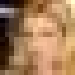

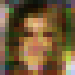

epoch =  397
Epoch [396/500], Step [438/438], d_loss: -0.0619, g_loss: -0.3381, D(x): 0.45, D(G(z)): 0.28


Epoch: 399: 100%|██████████| 438/438 [00:24<00:00, 17.75it/s, D_total_loss=-.093, G_loss=-.4, fake_score=0.27, real_score=0.478]


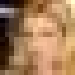

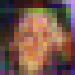

epoch =  399
Epoch [398/500], Step [438/438], d_loss: -0.0930, g_loss: -0.3998, D(x): 0.48, D(G(z)): 0.27


Epoch: 401: 100%|██████████| 438/438 [00:24<00:00, 18.00it/s, D_total_loss=-.194, G_loss=-.47, fake_score=0.201, real_score=0.442]


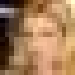

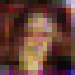

epoch =  401
Epoch [400/500], Step [438/438], d_loss: -0.1941, g_loss: -0.4696, D(x): 0.44, D(G(z)): 0.20


Epoch: 403: 100%|██████████| 438/438 [00:24<00:00, 18.06it/s, D_total_loss=-.0896, G_loss=-.206, fake_score=0.286, real_score=0.604]


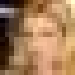

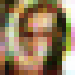

epoch =  403
Epoch [402/500], Step [438/438], d_loss: -0.0896, g_loss: -0.2055, D(x): 0.60, D(G(z)): 0.29


Epoch: 405: 100%|██████████| 438/438 [00:24<00:00, 17.89it/s, D_total_loss=-.168, G_loss=-.335, fake_score=0.233, real_score=0.445]


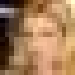

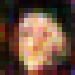

epoch =  405
Epoch [404/500], Step [438/438], d_loss: -0.1676, g_loss: -0.3354, D(x): 0.45, D(G(z)): 0.23


Epoch: 407: 100%|██████████| 438/438 [00:24<00:00, 18.13it/s, D_total_loss=-.281, G_loss=-.311, fake_score=0.167, real_score=0.546]


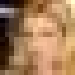

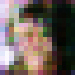

epoch =  407
Epoch [406/500], Step [438/438], d_loss: -0.2808, g_loss: -0.3112, D(x): 0.55, D(G(z)): 0.17


Epoch: 409: 100%|██████████| 438/438 [00:24<00:00, 17.89it/s, D_total_loss=-.271, G_loss=-.32, fake_score=0.266, real_score=0.654]


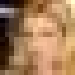

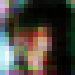

epoch =  409
Epoch [408/500], Step [438/438], d_loss: -0.2714, g_loss: -0.3198, D(x): 0.65, D(G(z)): 0.27


Epoch: 411: 100%|██████████| 438/438 [00:24<00:00, 18.15it/s, D_total_loss=-.161, G_loss=-.384, fake_score=0.336, real_score=0.62]


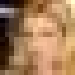

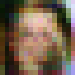

epoch =  411
Epoch [410/500], Step [438/438], d_loss: -0.1614, g_loss: -0.3837, D(x): 0.62, D(G(z)): 0.34


Epoch: 413: 100%|██████████| 438/438 [00:24<00:00, 17.63it/s, D_total_loss=0.0749, G_loss=-.441, fake_score=0.28, real_score=0.75]


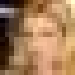

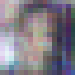

epoch =  413
Epoch [412/500], Step [438/438], d_loss: 0.0749, g_loss: -0.4410, D(x): 0.75, D(G(z)): 0.28


Epoch: 415: 100%|██████████| 438/438 [00:24<00:00, 18.20it/s, D_total_loss=-.257, G_loss=-.499, fake_score=0.299, real_score=0.632]


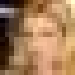

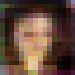

epoch =  415
Epoch [414/500], Step [438/438], d_loss: -0.2572, g_loss: -0.4991, D(x): 0.63, D(G(z)): 0.30


Epoch: 417: 100%|██████████| 438/438 [00:24<00:00, 17.99it/s, D_total_loss=-.33, G_loss=-.621, fake_score=0.314, real_score=0.706]


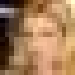

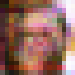

epoch =  417
Epoch [416/500], Step [438/438], d_loss: -0.3300, g_loss: -0.6205, D(x): 0.71, D(G(z)): 0.31


Epoch: 419: 100%|██████████| 438/438 [00:24<00:00, 17.67it/s, D_total_loss=-.27, G_loss=-.58, fake_score=0.441, real_score=0.77]


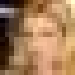

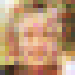

epoch =  419
Epoch [418/500], Step [438/438], d_loss: -0.2702, g_loss: -0.5797, D(x): 0.77, D(G(z)): 0.44


Epoch: 421: 100%|██████████| 438/438 [00:24<00:00, 18.09it/s, D_total_loss=0.151, G_loss=-.381, fake_score=0.355, real_score=0.455]


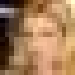

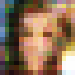

epoch =  421
Epoch [420/500], Step [438/438], d_loss: 0.1513, g_loss: -0.3813, D(x): 0.46, D(G(z)): 0.36


Epoch: 423: 100%|██████████| 438/438 [00:24<00:00, 18.12it/s, D_total_loss=0.109, G_loss=-.315, fake_score=0.362, real_score=0.524]


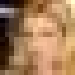

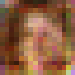

epoch =  423
Epoch [422/500], Step [438/438], d_loss: 0.1089, g_loss: -0.3145, D(x): 0.52, D(G(z)): 0.36


Epoch: 425: 100%|██████████| 438/438 [00:24<00:00, 17.79it/s, D_total_loss=0.104, G_loss=-.453, fake_score=0.365, real_score=0.407]


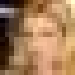

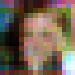

epoch =  425
Epoch [424/500], Step [438/438], d_loss: 0.1039, g_loss: -0.4533, D(x): 0.41, D(G(z)): 0.37


Epoch: 427: 100%|██████████| 438/438 [00:24<00:00, 18.11it/s, D_total_loss=-.195, G_loss=-.505, fake_score=0.485, real_score=0.704]


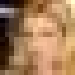

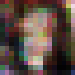

epoch =  427
Epoch [426/500], Step [438/438], d_loss: -0.1952, g_loss: -0.5049, D(x): 0.70, D(G(z)): 0.48


Epoch: 429: 100%|██████████| 438/438 [00:24<00:00, 17.98it/s, D_total_loss=0.159, G_loss=-.462, fake_score=0.513, real_score=0.726]


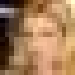

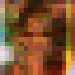

epoch =  429
Epoch [428/500], Step [438/438], d_loss: 0.1595, g_loss: -0.4624, D(x): 0.73, D(G(z)): 0.51


Epoch: 431: 100%|██████████| 438/438 [00:24<00:00, 17.94it/s, D_total_loss=-.32, G_loss=-.497, fake_score=0.449, real_score=0.837]


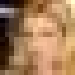

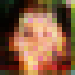

epoch =  431
Epoch [430/500], Step [438/438], d_loss: -0.3195, g_loss: -0.4970, D(x): 0.84, D(G(z)): 0.45


Epoch: 433: 100%|██████████| 438/438 [00:24<00:00, 18.03it/s, D_total_loss=-.0782, G_loss=-.417, fake_score=0.554, real_score=0.835]


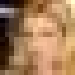

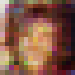

epoch =  433
Epoch [432/500], Step [438/438], d_loss: -0.0782, g_loss: -0.4169, D(x): 0.83, D(G(z)): 0.55


Epoch: 435: 100%|██████████| 438/438 [00:24<00:00, 17.87it/s, D_total_loss=0.142, G_loss=-.568, fake_score=0.485, real_score=0.61]


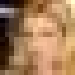

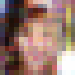

epoch =  435
Epoch [434/500], Step [438/438], d_loss: 0.1418, g_loss: -0.5684, D(x): 0.61, D(G(z)): 0.48


Epoch: 437: 100%|██████████| 438/438 [00:24<00:00, 17.86it/s, D_total_loss=0.0171, G_loss=-.453, fake_score=0.514, real_score=0.675]


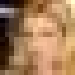

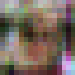

epoch =  437
Epoch [436/500], Step [438/438], d_loss: 0.0171, g_loss: -0.4535, D(x): 0.68, D(G(z)): 0.51


Epoch: 439: 100%|██████████| 438/438 [00:24<00:00, 17.91it/s, D_total_loss=0.535, G_loss=-.699, fake_score=0.664, real_score=0.76]


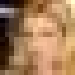

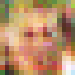

epoch =  439
Epoch [438/500], Step [438/438], d_loss: 0.5354, g_loss: -0.6987, D(x): 0.76, D(G(z)): 0.66


Epoch: 441: 100%|██████████| 438/438 [00:24<00:00, 17.93it/s, D_total_loss=-.267, G_loss=-.543, fake_score=0.315, real_score=0.718]


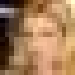

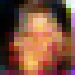

epoch =  441
Epoch [440/500], Step [438/438], d_loss: -0.2668, g_loss: -0.5427, D(x): 0.72, D(G(z)): 0.32


Epoch: 443: 100%|██████████| 438/438 [00:24<00:00, 17.82it/s, D_total_loss=-.0903, G_loss=-.483, fake_score=0.531, real_score=0.754]


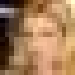

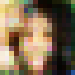

epoch =  443
Epoch [442/500], Step [438/438], d_loss: -0.0903, g_loss: -0.4830, D(x): 0.75, D(G(z)): 0.53


Epoch: 445: 100%|██████████| 438/438 [00:23<00:00, 18.28it/s, D_total_loss=-.0478, G_loss=-.568, fake_score=0.489, real_score=0.601]


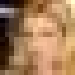

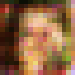

epoch =  445
Epoch [444/500], Step [438/438], d_loss: -0.0478, g_loss: -0.5676, D(x): 0.60, D(G(z)): 0.49


Epoch: 447: 100%|██████████| 438/438 [00:23<00:00, 18.42it/s, D_total_loss=-.0787, G_loss=-.56, fake_score=0.589, real_score=0.758]


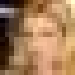

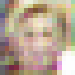

epoch =  447
Epoch [446/500], Step [438/438], d_loss: -0.0787, g_loss: -0.5595, D(x): 0.76, D(G(z)): 0.59


Epoch: 449: 100%|██████████| 438/438 [00:24<00:00, 17.90it/s, D_total_loss=-.259, G_loss=-.569, fake_score=0.352, real_score=0.839]


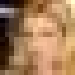

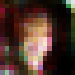

epoch =  449
Epoch [448/500], Step [438/438], d_loss: -0.2594, g_loss: -0.5693, D(x): 0.84, D(G(z)): 0.35


Epoch: 451: 100%|██████████| 438/438 [00:24<00:00, 18.02it/s, D_total_loss=-.233, G_loss=-.609, fake_score=0.34, real_score=0.645]


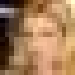

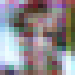

epoch =  451
Epoch [450/500], Step [438/438], d_loss: -0.2332, g_loss: -0.6087, D(x): 0.65, D(G(z)): 0.34


Epoch: 453: 100%|██████████| 438/438 [00:24<00:00, 17.87it/s, D_total_loss=0.528, G_loss=-.631, fake_score=0.605, real_score=0.727]


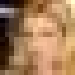

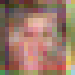

epoch =  453
Epoch [452/500], Step [438/438], d_loss: 0.5277, g_loss: -0.6309, D(x): 0.73, D(G(z)): 0.61


Epoch: 455: 100%|██████████| 438/438 [00:24<00:00, 17.73it/s, D_total_loss=0.312, G_loss=-.47, fake_score=0.593, real_score=0.724]


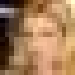

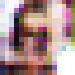

epoch =  455
Epoch [454/500], Step [438/438], d_loss: 0.3119, g_loss: -0.4696, D(x): 0.72, D(G(z)): 0.59


Epoch: 457: 100%|██████████| 438/438 [00:24<00:00, 17.82it/s, D_total_loss=-.0659, G_loss=-.658, fake_score=0.477, real_score=0.619]


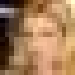

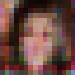

epoch =  457
Epoch [456/500], Step [438/438], d_loss: -0.0659, g_loss: -0.6576, D(x): 0.62, D(G(z)): 0.48


Epoch: 459: 100%|██████████| 438/438 [00:24<00:00, 17.88it/s, D_total_loss=-.369, G_loss=-.547, fake_score=0.342, real_score=0.783]


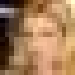

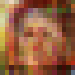

epoch =  459
Epoch [458/500], Step [438/438], d_loss: -0.3692, g_loss: -0.5466, D(x): 0.78, D(G(z)): 0.34


Epoch: 461: 100%|██████████| 438/438 [00:24<00:00, 17.75it/s, D_total_loss=0.032, G_loss=-.573, fake_score=0.62, real_score=0.747]


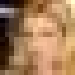

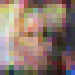

epoch =  461
Epoch [460/500], Step [438/438], d_loss: 0.0320, g_loss: -0.5731, D(x): 0.75, D(G(z)): 0.62


Epoch: 463: 100%|██████████| 438/438 [00:23<00:00, 18.33it/s, D_total_loss=-.178, G_loss=-.425, fake_score=0.524, real_score=0.734]


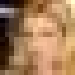

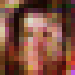

epoch =  463
Epoch [462/500], Step [438/438], d_loss: -0.1779, g_loss: -0.4246, D(x): 0.73, D(G(z)): 0.52


Epoch: 465: 100%|██████████| 438/438 [00:24<00:00, 17.61it/s, D_total_loss=0.0709, G_loss=-.543, fake_score=0.436, real_score=0.715]


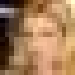

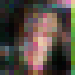

epoch =  465
Epoch [464/500], Step [438/438], d_loss: 0.0709, g_loss: -0.5433, D(x): 0.72, D(G(z)): 0.44


Epoch: 467: 100%|██████████| 438/438 [00:24<00:00, 18.23it/s, D_total_loss=0.115, G_loss=-.549, fake_score=0.632, real_score=0.561]


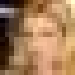

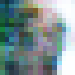

epoch =  467
Epoch [466/500], Step [438/438], d_loss: 0.1150, g_loss: -0.5485, D(x): 0.56, D(G(z)): 0.63


Epoch: 469: 100%|██████████| 438/438 [00:24<00:00, 18.09it/s, D_total_loss=-.0345, G_loss=-.512, fake_score=0.523, real_score=0.748]


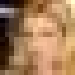

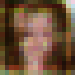

epoch =  469
Epoch [468/500], Step [438/438], d_loss: -0.0345, g_loss: -0.5122, D(x): 0.75, D(G(z)): 0.52


Epoch: 471: 100%|██████████| 438/438 [00:24<00:00, 17.73it/s, D_total_loss=-.106, G_loss=-.677, fake_score=0.446, real_score=0.622]


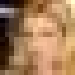

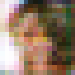

epoch =  471
Epoch [470/500], Step [438/438], d_loss: -0.1059, g_loss: -0.6770, D(x): 0.62, D(G(z)): 0.45


Epoch: 473: 100%|██████████| 438/438 [00:24<00:00, 18.08it/s, D_total_loss=0.139, G_loss=-.616, fake_score=0.61, real_score=0.706]


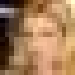

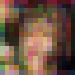

epoch =  473
Epoch [472/500], Step [438/438], d_loss: 0.1387, g_loss: -0.6158, D(x): 0.71, D(G(z)): 0.61


Epoch: 475: 100%|██████████| 438/438 [00:24<00:00, 17.99it/s, D_total_loss=-.0951, G_loss=-.558, fake_score=0.536, real_score=0.748]


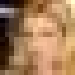

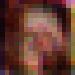

epoch =  475
Epoch [474/500], Step [438/438], d_loss: -0.0951, g_loss: -0.5578, D(x): 0.75, D(G(z)): 0.54


Epoch: 477: 100%|██████████| 438/438 [00:24<00:00, 18.02it/s, D_total_loss=0.0926, G_loss=-.772, fake_score=0.432, real_score=0.818]


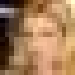

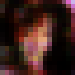

epoch =  477
Epoch [476/500], Step [438/438], d_loss: 0.0926, g_loss: -0.7716, D(x): 0.82, D(G(z)): 0.43


Epoch: 479: 100%|██████████| 438/438 [00:23<00:00, 18.40it/s, D_total_loss=0.139, G_loss=-.68, fake_score=0.481, real_score=0.527]


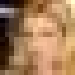

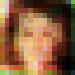

epoch =  479
Epoch [478/500], Step [438/438], d_loss: 0.1390, g_loss: -0.6801, D(x): 0.53, D(G(z)): 0.48


Epoch: 481: 100%|██████████| 438/438 [00:24<00:00, 18.02it/s, D_total_loss=0.0682, G_loss=-.593, fake_score=0.623, real_score=0.713]


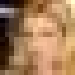

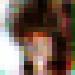

epoch =  481
Epoch [480/500], Step [438/438], d_loss: 0.0682, g_loss: -0.5934, D(x): 0.71, D(G(z)): 0.62


Epoch: 483: 100%|██████████| 438/438 [00:24<00:00, 18.09it/s, D_total_loss=0.129, G_loss=-.525, fake_score=0.564, real_score=0.86]


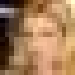

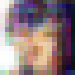

epoch =  483
Epoch [482/500], Step [438/438], d_loss: 0.1286, g_loss: -0.5254, D(x): 0.86, D(G(z)): 0.56


Epoch: 485: 100%|██████████| 438/438 [00:23<00:00, 18.47it/s, D_total_loss=-.107, G_loss=-.556, fake_score=0.457, real_score=0.626]


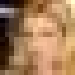

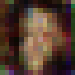

epoch =  485
Epoch [484/500], Step [438/438], d_loss: -0.1073, g_loss: -0.5564, D(x): 0.63, D(G(z)): 0.46


Epoch: 487: 100%|██████████| 438/438 [00:24<00:00, 18.21it/s, D_total_loss=-.165, G_loss=-.652, fake_score=0.666, real_score=0.877]


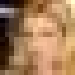

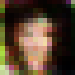

epoch =  487
Epoch [486/500], Step [438/438], d_loss: -0.1651, g_loss: -0.6520, D(x): 0.88, D(G(z)): 0.67


Epoch: 489: 100%|██████████| 438/438 [00:24<00:00, 18.05it/s, D_total_loss=0.165, G_loss=-.683, fake_score=0.539, real_score=0.694]


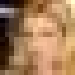

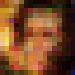

epoch =  489
Epoch [488/500], Step [438/438], d_loss: 0.1653, g_loss: -0.6831, D(x): 0.69, D(G(z)): 0.54


Epoch: 491: 100%|██████████| 438/438 [00:24<00:00, 17.88it/s, D_total_loss=0.331, G_loss=-.697, fake_score=0.647, real_score=0.752]


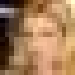

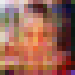

epoch =  491
Epoch [490/500], Step [438/438], d_loss: 0.3314, g_loss: -0.6965, D(x): 0.75, D(G(z)): 0.65


Epoch: 493: 100%|██████████| 438/438 [00:23<00:00, 18.27it/s, D_total_loss=-.295, G_loss=-.655, fake_score=0.565, real_score=0.935]


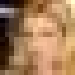

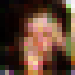

epoch =  493
Epoch [492/500], Step [438/438], d_loss: -0.2946, g_loss: -0.6549, D(x): 0.93, D(G(z)): 0.56


Epoch: 495: 100%|██████████| 438/438 [00:24<00:00, 17.81it/s, D_total_loss=-.236, G_loss=-.548, fake_score=0.452, real_score=0.72]


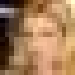

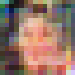

epoch =  495
Epoch [494/500], Step [438/438], d_loss: -0.2363, g_loss: -0.5485, D(x): 0.72, D(G(z)): 0.45


Epoch: 497: 100%|██████████| 438/438 [00:23<00:00, 18.29it/s, D_total_loss=-.2, G_loss=-.613, fake_score=0.504, real_score=0.894]


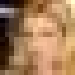

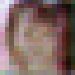

epoch =  497
Epoch [496/500], Step [438/438], d_loss: -0.1997, g_loss: -0.6126, D(x): 0.89, D(G(z)): 0.50


Epoch: 499: 100%|██████████| 438/438 [00:23<00:00, 18.40it/s, D_total_loss=-.0952, G_loss=-.63, fake_score=0.68, real_score=0.853]


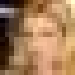

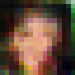

epoch =  499
Epoch [498/500], Step [438/438], d_loss: -0.0952, g_loss: -0.6303, D(x): 0.85, D(G(z)): 0.68


Epoch: 500: 100%|██████████| 438/438 [00:23<00:00, 18.41it/s, D_total_loss=-.125, G_loss=-.642, fake_score=0.524, real_score=0.776]


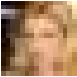

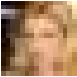

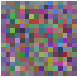

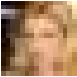

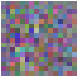

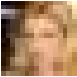

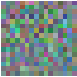

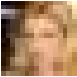

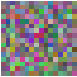

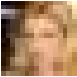

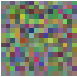

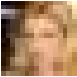

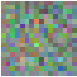

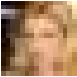

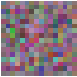

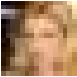

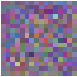

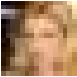

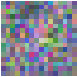

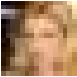

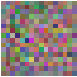

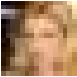

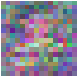

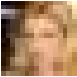

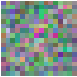

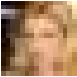

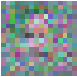

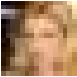

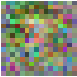

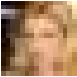

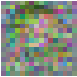

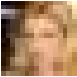

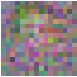

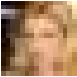

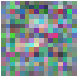

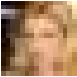

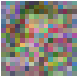

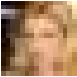

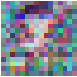

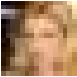

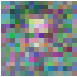

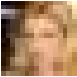

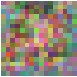

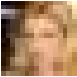

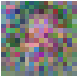

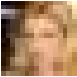

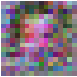

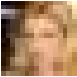

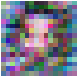

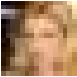

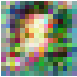

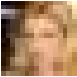

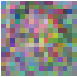

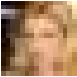

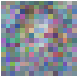

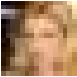

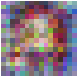

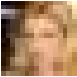

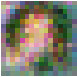

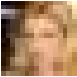

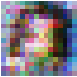

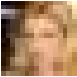

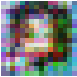

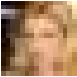

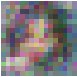

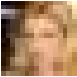

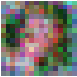

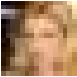

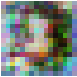

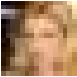

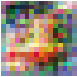

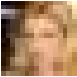

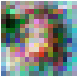

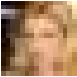

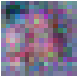

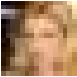

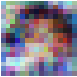

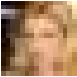

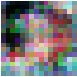

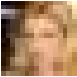

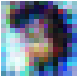

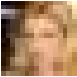

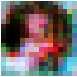

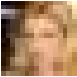

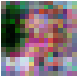

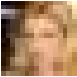

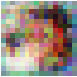

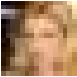

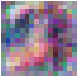

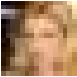

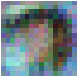

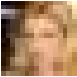

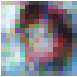

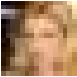

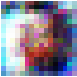

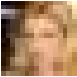

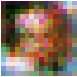

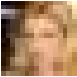

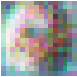

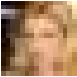

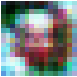

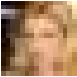

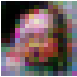

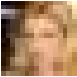

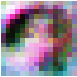

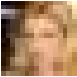

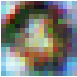

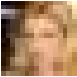

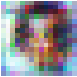

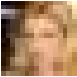

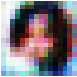

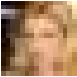

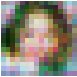

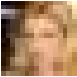

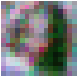

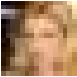

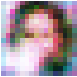

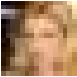

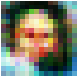

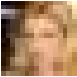

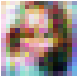

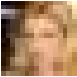

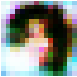

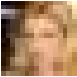

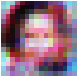

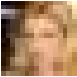

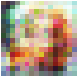

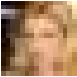

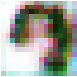

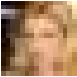

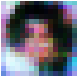

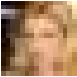

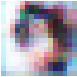

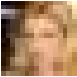

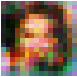

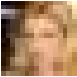

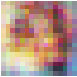

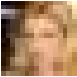

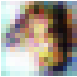

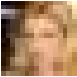

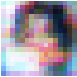

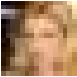

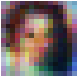

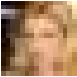

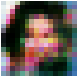

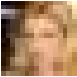

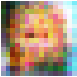

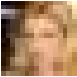

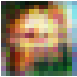

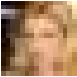

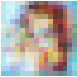

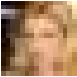

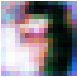

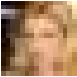

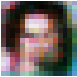

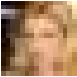

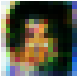

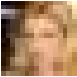

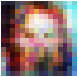

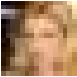

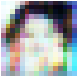

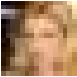

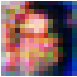

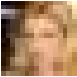

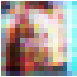

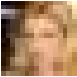

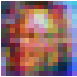

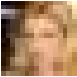

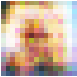

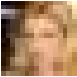

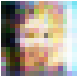

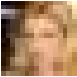

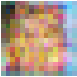

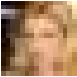

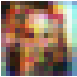

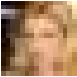

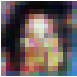

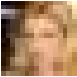

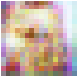

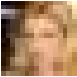

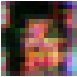

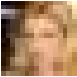

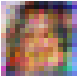

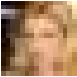

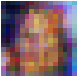

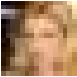

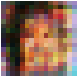

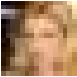

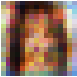

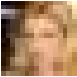

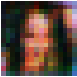

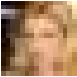

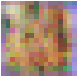

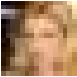

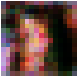

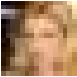

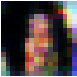

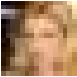

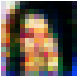

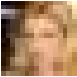

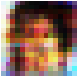

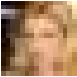

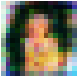

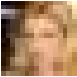

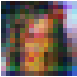

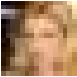

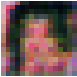

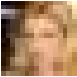

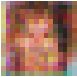

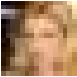

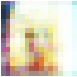

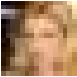

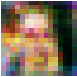

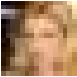

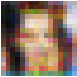

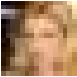

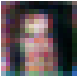

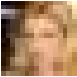

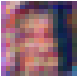

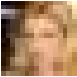

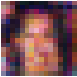

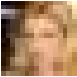

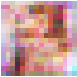

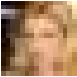

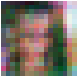

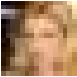

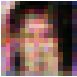

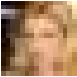

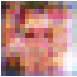

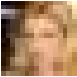

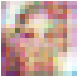

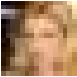

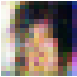

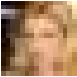

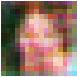

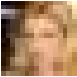

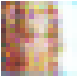

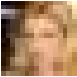

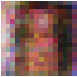

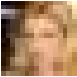

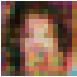

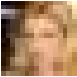

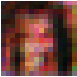

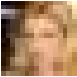

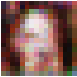

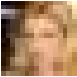

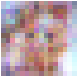

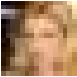

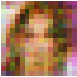

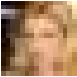

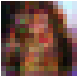

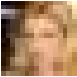

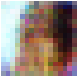

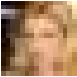

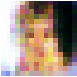

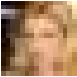

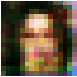

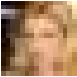

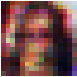

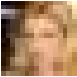

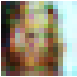

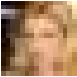

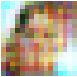

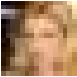

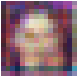

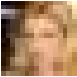

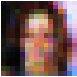

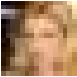

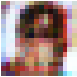

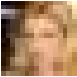

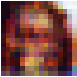

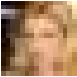

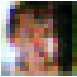

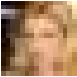

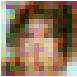

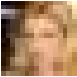

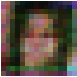

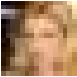

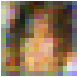

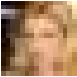

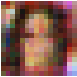

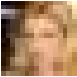

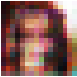

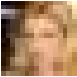

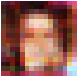

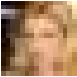

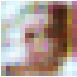

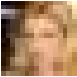

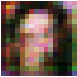

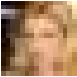

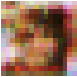

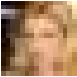

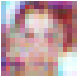

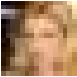

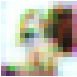

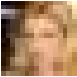

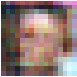

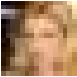

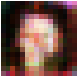

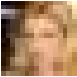

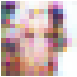

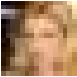

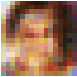

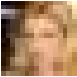

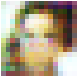

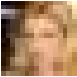

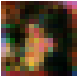

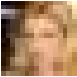

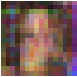

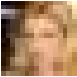

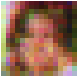

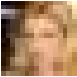

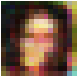

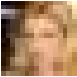

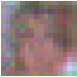

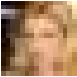

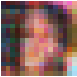

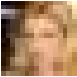

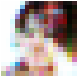

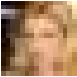

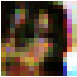

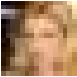

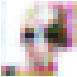

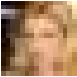

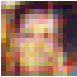

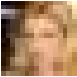

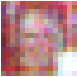

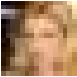

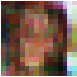

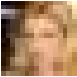

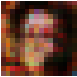

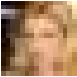

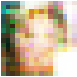

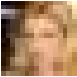

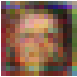

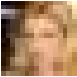

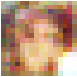

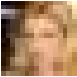

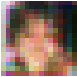

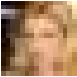

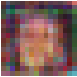

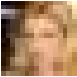

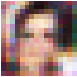

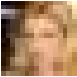

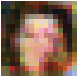

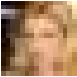

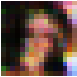

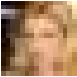

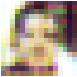

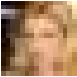

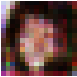

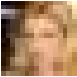

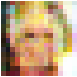

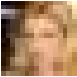

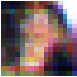

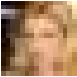

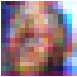

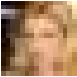

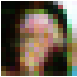

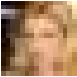

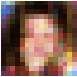

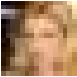

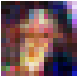

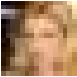

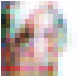

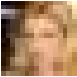

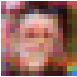

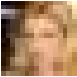

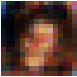

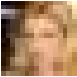

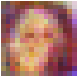

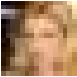

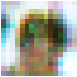

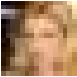

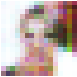

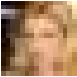

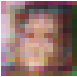

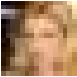

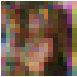

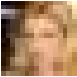

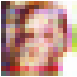

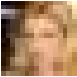

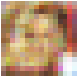

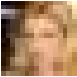

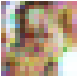

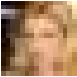

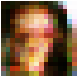

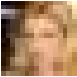

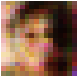

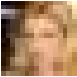

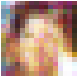

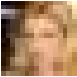

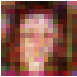

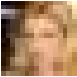

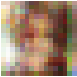

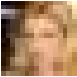

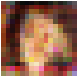

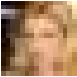

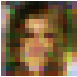

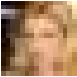

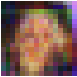

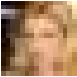

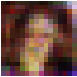

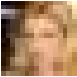

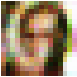

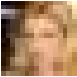

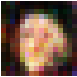

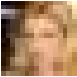

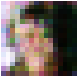

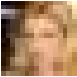

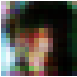

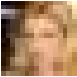

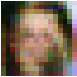

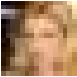

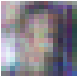

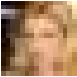

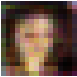

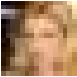

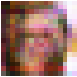

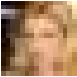

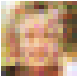

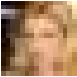

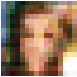

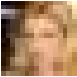

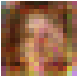

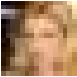

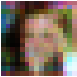

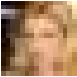

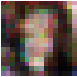

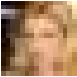

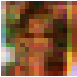

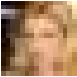

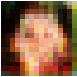

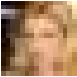

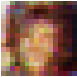

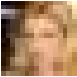

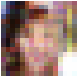

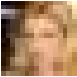

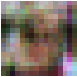

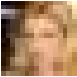

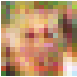

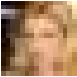

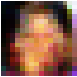

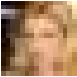

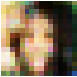

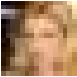

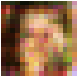

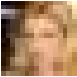

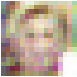

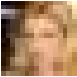

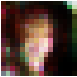

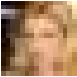

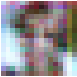

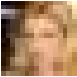

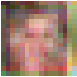

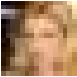

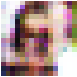

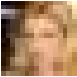

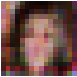

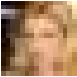

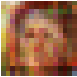

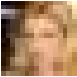

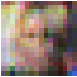

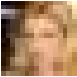

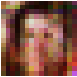

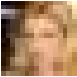

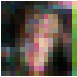

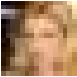

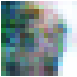

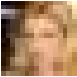

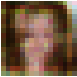

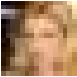

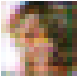

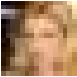

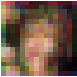

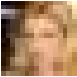

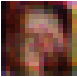

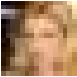

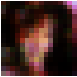

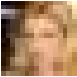

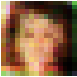

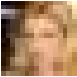

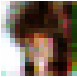

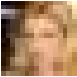

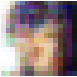

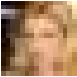

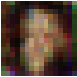

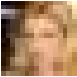

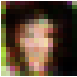

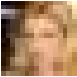

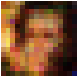

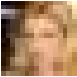

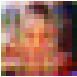

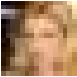

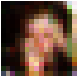

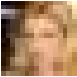

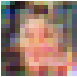

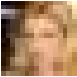

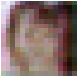

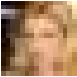

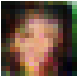

In [14]:
for i in range(iteration):

    p = tqdm(range(total_data_len // batch_size + 1)) # This is a progress bar run on each epoch
    
    datasets_batched = DataLoader(dataset, batch_size = batch_size)
    
    loader = iter(datasets_batched)

    d_step = 0

    for j in p:
        

        batchNum = str(i+1)
        
        #Training the D
        #real data
        real = next(loader).to(device)

        #current_batch size (the last batch is different than others)
        current_batch_size, c, h, w = real.shape
        #labels
        label_real = 0.1 * t.randint(7,10,(current_batch_size,1)).type(t.half)
        label_fake = 0.1 * t.randint(0,3,(current_batch_size,1)).type(t.half)

        real_score = discriminator(real)
        d_real_loss = -t.mean(real_score)
        
        input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
        fake = generator(input_noise, current_batch_size)
        fake_score = discriminator(fake)

        d_fake_loss = t.mean(fake_score)

        gradient_penalty = compute_gradient_penalty(discriminator, real, fake, current_batch_size)
        
        total_loss = d_fake_loss + d_real_loss + gradient_penalty

        generator.zero_grad()
        discriminator.zero_grad()
        total_loss.backward()
        D_optimizer.step()

        d_step += 1

        if d_step == updatD_step:

          discriminatorReal.load_state_dict(discriminator.state_dict().copy())




        if j % critic == 0:
          input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
          fake = generator(input_noise, current_batch_size)
          fake_score = discriminator(fake)
          g_fake_loss = -t.mean(fake_score)
          discriminator.zero_grad()
          generator.zero_grad()
          g_fake_loss.backward()
          G_optimizer.step()
          discriminator.load_state_dict(discriminatorReal.state_dict().copy())
          D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.00001)
          d_step = 0
          

        
        mse = "Epoch: " + batchNum
        
        p.set_description(mse)
            
        p.set_postfix(G_loss = g_fake_loss.item(), D_total_loss = total_loss.item(), real_score = real_score.mean().item(), fake_score = fake_score.mean().item())
        
    if i == 0:
        showOneImge(real[0], 99999, True)   
    
    if i % 2 == 0:
      
      showOneImge(real[0], 99999, False)
      showOneImge(fake[0], i, False)
      print("epoch = ", i + 1)  
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(i, iteration, j+1, total_data_len // batch_size + 1, total_loss.item(), g_fake_loss.item(), real_score.mean().item(), fake_score.mean().item()))      
      

    if i % 50 == 0:
      t.save(generator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_g.model')
      t.save(discriminator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_d.model')


### Show Result

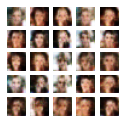

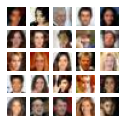

In [15]:


#Generated
generator.eval()

with t.no_grad():
  input_noise = t.normal(0, 1, size = (eval_size, 1, 1, laten_space)).to(device)
  generated = generator(input_noise, eval_size)
  showMoreImages(generated, eval_size)

#Real
datasets_batched = DataLoader(dataset, batch_size = eval_size)
loader = iter(datasets_batched)
real = next(loader)
showMoreImages(real, eval_size)

### remove log file when necessarry

In [16]:
# !rm -rf /content/log/checkpoint

# !mkdir /content/log/checkpoint

# !rm -rf /content/log/sample
# !mkdir /content/log/sample

# from google.colab import files
# files.download('/content/log') 